In [3]:
import pulp
import numpy as np

# Données de base (exemple simplifié)

components = range(10)           # 10 composants e=0..9
skills = [0,1]                   # 2 compétences s=0,1
employees = {                    # employés par compétence
    0: [0,1,2],                 # employés pour compétence 0
    1: [3,4]                    # employés pour compétence 1
}
days = range(7)                  # horizon 7 jours

# Paramètres fictifs
# Coûts main d'oeuvre par employé (arbitraire)
cost_main = {(e,s,p,t): 50 + 5*p for e in components for s in skills for p in employees[s] for t in days}
# Coûts pièces (fixes)
cost_piece = {(e,s,t): 100 for e in components for s in skills for t in days}
# Temps de travail requis (heures)
tau = {(e,s,p): 2 for e in components for s in skills for p in employees[s]}
# Temps dispo par employé par jour
phi = {p: 8 for p in range(5)}
# Disponibilité estimée (ici aléatoire pour l’exemple)
availability = {(e,t): 1.0 for e in components for t in days}
# Indicateur de panne (ici aléatoire)
panne = {(e,t): 0.1 for e in components for t in days}
# Nombre max employés dispo par compétence par jour
N = { (s,t): len(employees[s]) for s in skills for t in days}
# alpha : 1 si p peut faire s
alpha = {(s,p): 1 for s in skills for p in employees[s]}
# beta : 1 si maintenance impérative (pour test, quelques aléatoires)
beta = {(e,t): 1 if (e+t)%5==0 else 0 for e in components for t in days}
# delta tolérance
delta = 1

# Modèle
model = pulp.LpProblem("Maintenance_Predictive", pulp.LpMinimize)

# Variables
x = {}
z = {}
for e in components:
    for s in skills:
        for t in days:
            z[(e,s,t)] = pulp.LpVariable(f"z_{e}_{s}_{t}", cat="Binary")
            for p in employees[s]:
                x[(e,s,p,t)] = pulp.LpVariable(f"x_{e}_{s}_{p}_{t}", cat="Binary")

# Fonction objectif
model += (
    pulp.lpSum(cost_main[(e,s,p,t)] * x[(e,s,p,t)] for e in components for s in skills for p in employees[s] for t in days) +
    pulp.lpSum(cost_piece[(e,s,t)] * z[(e,s,t)] for e in components for s in skills for t in days) -
    10 * pulp.lpSum(availability[(e,t)] for e in components for t in days) +
    20 * pulp.lpSum(panne[(e,t)] for e in components for t in days)
)

# Contraintes

# 1. Assignation employés = maintenance planifiée
for e in components:
    for s in skills:
        for t in days:
            model += pulp.lpSum(alpha[(s,p)] * x[(e,s,p,t)] for p in employees[s]) == z[(e,s,t)]

# 2. Respect temps travail
for p in range(5):
    for t in days:
        model += pulp.lpSum(tau[(e,s,p)] * x[(e,s,p,t)] for e in components for s in skills if p in employees[s]) <= phi[p]

# 3. Nombre max employés dispo par compétence/jour
for s in skills:
    for t in days:
        model += pulp.lpSum(x[(e,s,p,t)] for e in components for p in employees[s]) <= N[(s,t)]

# 4. Maintenances obligatoires dans fenêtre delta
for e in components:
    for s in skills:
        for t in days:
            if beta[(e,t)] == 1:
                model += pulp.lpSum(z[(e,s,tp)] for tp in range(t, min(t+delta+1, len(days)))) == 1

# Résoudre
solver = pulp.PULP_CBC_CMD(msg=1)  # solver par défaut
result = model.solve(solver)

# Résultats
print("Status:", pulp.LpStatus[result])
for e in components:
    for s in skills:
        for t in days:
            if pulp.value(z[(e,s,t)]) > 0.5:
                affectes = [p for p in employees[s] if pulp.value(x[(e,s,p,t)]) > 0.5]
                print(f"Composant {e}, compétence {s}, jour {t} --> Maintenance planifiée, employés affectés: {affectes}")


Status: Optimal
Composant 0, compétence 0, jour 0 --> Maintenance planifiée, employés affectés: [0]
Composant 0, compétence 0, jour 5 --> Maintenance planifiée, employés affectés: [0]
Composant 0, compétence 1, jour 0 --> Maintenance planifiée, employés affectés: [3]
Composant 0, compétence 1, jour 5 --> Maintenance planifiée, employés affectés: [3]
Composant 1, compétence 0, jour 4 --> Maintenance planifiée, employés affectés: [0]
Composant 1, compétence 1, jour 4 --> Maintenance planifiée, employés affectés: [3]
Composant 2, compétence 0, jour 3 --> Maintenance planifiée, employés affectés: [0]
Composant 2, compétence 1, jour 3 --> Maintenance planifiée, employés affectés: [3]
Composant 3, compétence 0, jour 2 --> Maintenance planifiée, employés affectés: [0]
Composant 3, compétence 1, jour 2 --> Maintenance planifiée, employés affectés: [3]
Composant 4, compétence 0, jour 1 --> Maintenance planifiée, employés affectés: [0]
Composant 4, compétence 0, jour 6 --> Maintenance planifiée,

Status: Infeasible

--- Planning Maintenance ---
    Composant  Compétence  Jour Employés affectés
0           0           0     0                 2
1           0           0     4                  
2           0           1     0                 0
3           0           1     4                  
4           0           2     0                  
5           0           2     3                  
6           1           0     0                 2
7           1           1     1                  
8           1           2     0                 3
9           2           0     1                 0
10          2           1     1                  
11          2           2     1                  
12          3           0     0                 2
13          3           0     2                  
14          3           1     0                  
15          3           1     2                  
16          3           2     1                  
17          3           2     3                  
1

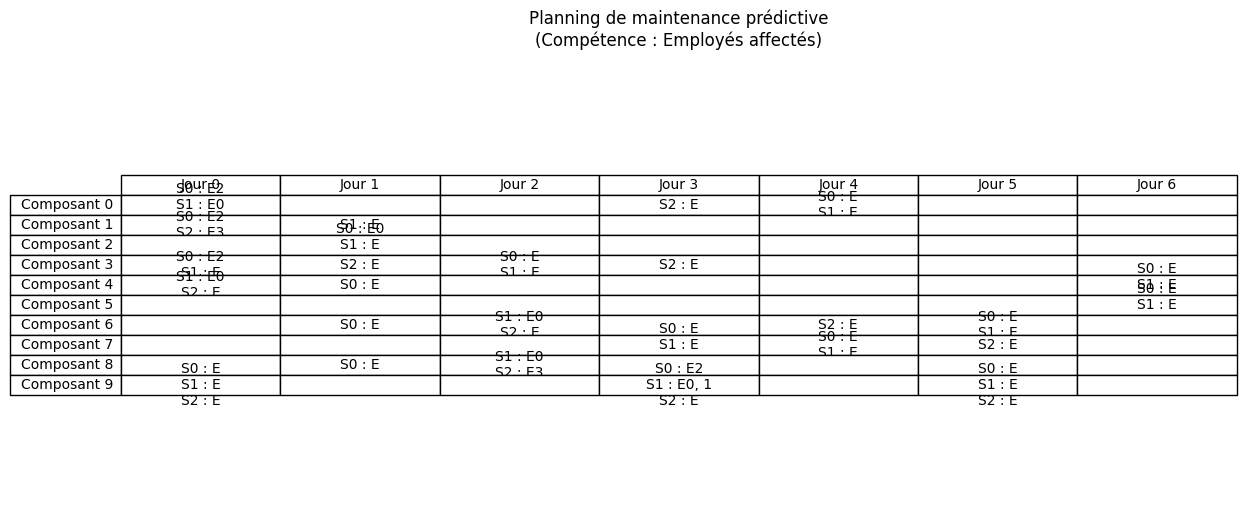

In [5]:
import pulp
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------
# Génération données réalistes
# -----------------------

np.random.seed(42)
random.seed(42)

components = list(range(10))   # 10 composants
skills = [0,1,2]              # 0=Inspection,1=Remplacement,2=Réglage
days = list(range(7))         # 7 jours

# Techniciens avec compétences
employees = {
    0: [0,1],   # technicien 0
    1: [1,2],   # technicien 1
    2: [0],     # technicien 2
    3: [2],     # technicien 3
    4: [0,2]    # technicien 4
}

# Compétences -> techniciens
employees_by_skill = {s: [] for s in skills}
for p, s_list in employees.items():
    for s in s_list:
        employees_by_skill[s].append(p)

# Durée maintenance (heures)
tau = {}
for e in components:
    for s in skills:
        for p in employees_by_skill[s]:
            base = {0:1.5, 1:3.0, 2:2.0}[s]
            tau[(e,s,p)] = round(random.uniform(base*0.8, base*1.2),2)

# Temps dispo par technicien (heures/jour)
phi = {p: 8 for p in employees.keys()}

# Coût horaire par technicien (€)
hourly_cost = {0:30,1:35,2:28,3:25,4:32}
cost_main = {}
for e in components:
    for s in skills:
        for p in employees_by_skill[s]:
            for t in days:
                cost_main[(e,s,p,t)] = tau[(e,s,p)] * hourly_cost[p]

# Coût pièces par maintenance (€)
cost_piece = {}
for e in components:
    for s in skills:
        base_piece = {0:20,1:150,2:50}[s]
        for t in days:
            cost_piece[(e,s,t)] = round(random.uniform(base_piece*0.9, base_piece*1.1),2)

# Nombre max employés dispo par compétence/jour (max 2)
N = {(s,t): min(2,len(employees_by_skill[s])) for s in skills for t in days}

# alpha(s,p) = 1 si p peut faire s
alpha = {}
for s in skills:
    for p in employees_by_skill[s]:
        alpha[(s,p)] = 1

# Maintenance obligatoire beta(e,t) aléatoire (~30% de chance)
beta = {}
for e in components:
    for t in days:
        beta[(e,t)] = 1 if random.random() < 0.3 else 0

delta = 1  # tolérance maintenance

# Stock pièces par type et jour
M = {}
for s in skills:
    for t in days:
        M[(s,t)] = random.randint(1,4)

# kappa(e,s,r) = 1 si pièce r nécessaire pour maintenance s
kappa = {}
for e in components:
    for s in skills:
        for r in skills:
            kappa[(e,s,r)] = 1 if s==r else 0

# Disponibilité et pannes (fonction de beta)
availability = {}
panne = {}
for e in components:
    for t in days:
        availability[(e,t)] = round(0.8 + 0.2*(1 - beta[(e,t)]),2)
        panne[(e,t)] = round(0.05 + 0.3*beta[(e,t)],2)

# -----------------------
# Construction modèle MILP
# -----------------------

model = pulp.LpProblem("Maintenance_Predictive", pulp.LpMinimize)

# Variables
x = {}
z = {}
for e in components:
    for s in skills:
        for t in days:
            z[(e,s,t)] = pulp.LpVariable(f"z_{e}_{s}_{t}", cat="Binary")
            for p in employees_by_skill[s]:
                x[(e,s,p,t)] = pulp.LpVariable(f"x_{e}_{s}_{p}_{t}", cat="Binary")

# Fonction objectif
model += (
    pulp.lpSum(cost_main[(e,s,p,t)] * x[(e,s,p,t)] for e in components for s in skills for p in employees_by_skill[s] for t in days) +
    pulp.lpSum(cost_piece[(e,s,t)] * z[(e,s,t)] for e in components for s in skills for t in days) -
    10 * pulp.lpSum(availability[(e,t)] for e in components for t in days) +
    20 * pulp.lpSum(panne[(e,t)] for e in components for t in days)
)

# Contraintes

# 1. Assignation employés = maintenance planifiée
for e in components:
    for s in skills:
        for t in days:
            model += pulp.lpSum(alpha[(s,p)] * x[(e,s,p,t)] for p in employees_by_skill[s]) == z[(e,s,t)]

# 2. Respect temps travail employés
for p in employees.keys():
    for t in days:
        model += pulp.lpSum(tau[(e,s,p)] * x[(e,s,p,t)] for e in components for s in skills if p in employees_by_skill[s]) <= phi[p]

# 3. Max employés dispo par compétence et jour
for s in skills:
    for t in days:
        model += pulp.lpSum(x[(e,s,p,t)] for e in components for p in employees_by_skill[s]) <= N[(s,t)]

# 4. Maintenances obligatoires dans fenêtre delta
for e in components:
    for s in skills:
        for t in days:
            if beta[(e,t)] == 1:
                model += pulp.lpSum(z[(e,s,tp)] for tp in range(t, min(t+delta+1, len(days)))) == 1

# 5. Stock pièces limité
for r in skills:
    for t in days:
        model += pulp.lpSum(kappa[(e,s,r)] * z[(e,s,t)] for e in components for s in skills) <= M[(r,t)]

# Résolution
solver = pulp.PULP_CBC_CMD(msg=1)
result = model.solve(solver)
print("Status:", pulp.LpStatus[result])

# -----------------------
# Construction DataFrame planning
# -----------------------

planning = []
for e in components:
    for s in skills:
        for t in days:
            if pulp.value(z[(e,s,t)]) > 0.5:
                affectes = [p for p in employees_by_skill[s] if pulp.value(x[(e,s,p,t)]) > 0.5]
                planning.append({
                    "Composant": e,
                    "Compétence": s,
                    "Jour": t,
                    "Employés affectés": ", ".join(map(str, affectes))
                })

df = pd.DataFrame(planning)

print("\n--- Planning Maintenance ---")
print(df)

# -----------------------
# Affichage graphique tableau planning
# -----------------------

table_data = []
for e in components:
    row = []
    for t in days:
        lignes = df[(df["Composant"]==e) & (df["Jour"]==t)]
        if lignes.empty:
            row.append("")
        else:
            txt = []
            for idx, r in lignes.iterrows():
                txt.append(f"S{r['Compétence']} : E{r['Employés affectés']}")
            row.append("\n".join(txt))
    table_data.append(row)

fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('off')
tbl = ax.table(cellText=table_data,
               rowLabels=[f"Composant {e}" for e in components],
               colLabels=[f"Jour {t}" for t in days],
               cellLoc='center',
               loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 1.2)

plt.title("Planning de maintenance prédictive\n(Compétence : Employés affectés)")
plt.show()


Status: Infeasible


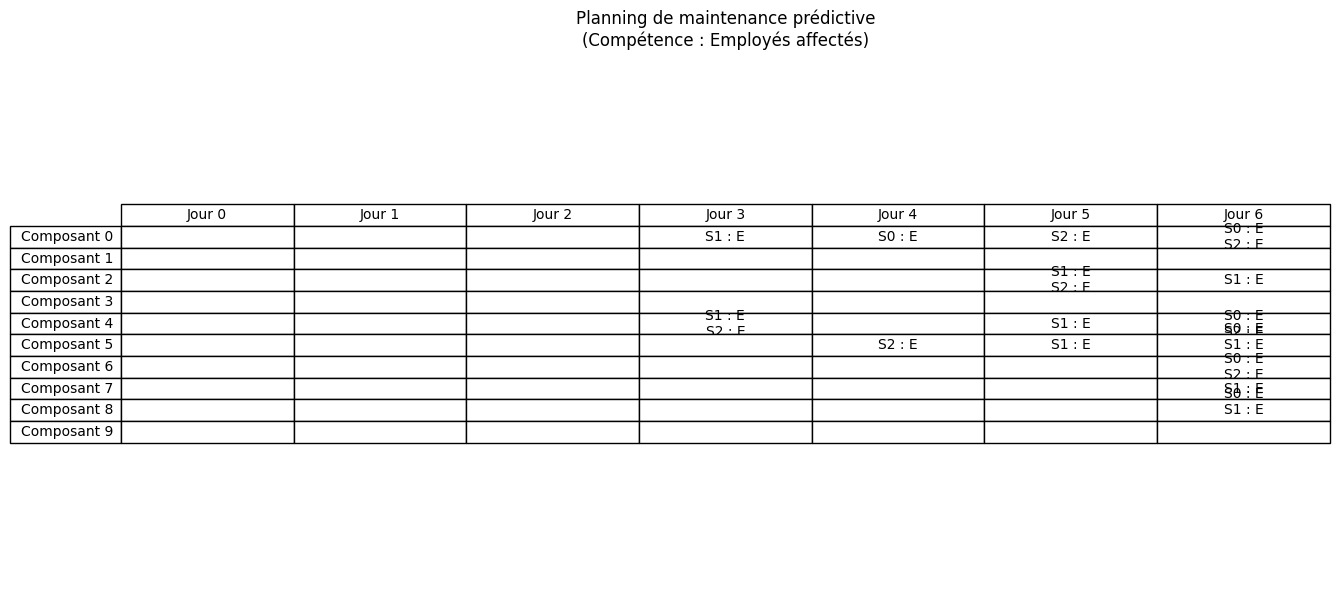

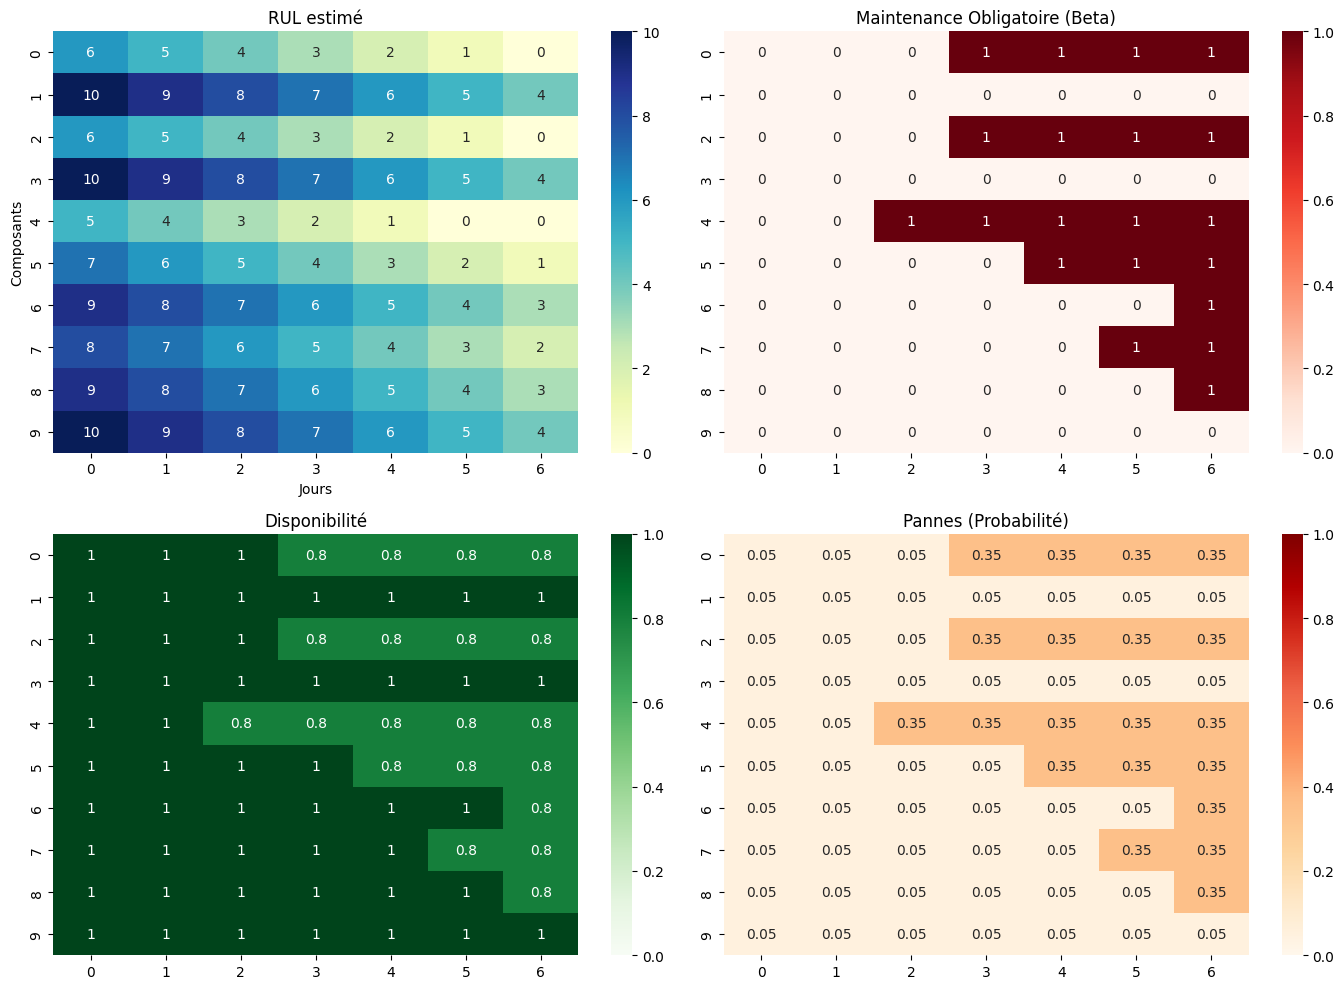

In [6]:
import pulp
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# DONNEES REALISTES + RUL SIMULE
# ---------------------------

np.random.seed(42)
random.seed(42)

components = list(range(10))
skills = [0,1,2]
days = list(range(7))

employees = {
    0: [0,1],
    1: [1,2],
    2: [0],
    3: [2],
    4: [0,2]
}
employees_by_skill = {s: [] for s in skills}
for p, s_list in employees.items():
    for s in s_list:
        employees_by_skill[s].append(p)

tau = {}
for e in components:
    for s in skills:
        for p in employees_by_skill[s]:
            base = {0:1.5, 1:3.0, 2:2.0}[s]
            tau[(e,s,p)] = round(random.uniform(base*0.8, base*1.2),2)

phi = {p: 8 for p in employees.keys()}

hourly_cost = {0:30,1:35,2:28,3:25,4:32}
cost_main = {}
for e in components:
    for s in skills:
        for p in employees_by_skill[s]:
            for t in days:
                cost_main[(e,s,p,t)] = tau[(e,s,p)] * hourly_cost[p]

cost_piece = {}
for e in components:
    for s in skills:
        base_piece = {0:20,1:150,2:50}[s]
        for t in days:
            cost_piece[(e,s,t)] = round(random.uniform(base_piece*0.9, base_piece*1.1),2)

N = {(s,t): min(2,len(employees_by_skill[s])) for s in skills for t in days}
alpha = {}
for s in skills:
    for p in employees_by_skill[s]:
        alpha[(s,p)] = 1

M = {}
for s in skills:
    for t in days:
        M[(s,t)] = random.randint(1,4)

kappa = {}
for e in components:
    for s in skills:
        for r in skills:
            kappa[(e,s,r)] = 1 if s==r else 0

# RUL simulé décroissant par composant et jour
max_rul = 10
rul = {}
for e in components:
    base = random.randint(5, max_rul)
    for t in days:
        val = max(base - t, 0)
        rul[(e,t)] = val

# Seuil critique
D = 3
beta = {}
for e in components:
    for t in days:
        beta[(e,t)] = 1 if rul[(e,t)] <= D else 0

availability = {}
panne = {}
for e in components:
    for t in days:
        availability[(e,t)] = round(0.8 + 0.2*(1 - beta[(e,t)]),2)
        panne[(e,t)] = round(0.05 + 0.3*beta[(e,t)],2)

delta = 1

# ---------------------------
# CONSTRUCTION MODELE MILP
# ---------------------------

model = pulp.LpProblem("Maintenance_Predictive", pulp.LpMinimize)

x = {}
z = {}
for e in components:
    for s in skills:
        for t in days:
            z[(e,s,t)] = pulp.LpVariable(f"z_{e}_{s}_{t}", cat="Binary")
            for p in employees_by_skill[s]:
                x[(e,s,p,t)] = pulp.LpVariable(f"x_{e}_{s}_{p}_{t}", cat="Binary")

model += (
    pulp.lpSum(cost_main[(e,s,p,t)] * x[(e,s,p,t)] for e in components for s in skills for p in employees_by_skill[s] for t in days) +
    pulp.lpSum(cost_piece[(e,s,t)] * z[(e,s,t)] for e in components for s in skills for t in days) -
    10 * pulp.lpSum(availability[(e,t)] for e in components for t in days) +
    20 * pulp.lpSum(panne[(e,t)] for e in components for t in days)
)

for e in components:
    for s in skills:
        for t in days:
            model += pulp.lpSum(alpha[(s,p)] * x[(e,s,p,t)] for p in employees_by_skill[s]) == z[(e,s,t)]

for p in employees.keys():
    for t in days:
        model += pulp.lpSum(tau[(e,s,p)] * x[(e,s,p,t)] for e in components for s in skills if p in employees_by_skill[s]) <= phi[p]

for s in skills:
    for t in days:
        model += pulp.lpSum(x[(e,s,p,t)] for e in components for p in employees_by_skill[s]) <= N[(s,t)]

for e in components:
    for s in skills:
        for t in days:
            if beta[(e,t)] == 1:
                model += pulp.lpSum(z[(e,s,tp)] for tp in range(t, min(t+delta+1, len(days)))) == 1

for r in skills:
    for t in days:
        model += pulp.lpSum(kappa[(e,s,r)] * z[(e,s,t)] for e in components for s in skills) <= M[(r,t)]

solver = pulp.PULP_CBC_CMD(msg=0)
result = model.solve(solver)
print("Status:", pulp.LpStatus[result])

# ---------------------------
# EXTRACTION PLANIFICATION
# ---------------------------

planning = []
for e in components:
    for s in skills:
        for t in days:
            if pulp.value(z[(e,s,t)]) > 0.5:
                affectes = [p for p in employees_by_skill[s] if pulp.value(x[(e,s,p,t)]) > 0.5]
                planning.append({
                    "Composant": e,
                    "Compétence": s,
                    "Jour": t,
                    "Employés affectés": ", ".join(map(str, affectes))
                })
df_plan = pd.DataFrame(planning)

# ---------------------------
# AFFICHAGE TABLEAU PLANIFICATION
# ---------------------------

table_data = []
for e in components:
    row = []
    for t in days:
        lignes = df_plan[(df_plan["Composant"]==e) & (df_plan["Jour"]==t)]
        if lignes.empty:
            row.append("")
        else:
            txt = []
            for idx, r in lignes.iterrows():
                txt.append(f"S{r['Compétence']} : E{r['Employés affectés']}")
            row.append("\n".join(txt))
    table_data.append(row)

fig, ax = plt.subplots(figsize=(12, 7))
ax.axis('off')
tbl = ax.table(cellText=table_data,
               rowLabels=[f"Composant {e}" for e in components],
               colLabels=[f"Jour {t}" for t in days],
               cellLoc='center',
               loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.3, 1.3)
plt.title("Planning de maintenance prédictive\n(Compétence : Employés affectés)")

# ---------------------------
# AFFICHAGE HEATMAPS INDICATEURS
# ---------------------------

def dict_to_matrix(d, rows, cols):
    mat = np.zeros((len(rows), len(cols)))
    for i,r in enumerate(rows):
        for j,c in enumerate(cols):
            mat[i,j] = d[(r,c)]
    return mat

fig2, axes = plt.subplots(2,2, figsize=(14,10))
sns.heatmap(dict_to_matrix(rul, components, days), ax=axes[0,0], annot=True, cmap="YlGnBu", cbar=True)
axes[0,0].set_title("RUL estimé")
axes[0,0].set_ylabel("Composants")
axes[0,0].set_xlabel("Jours")

sns.heatmap(dict_to_matrix(beta, components, days), ax=axes[0,1], annot=True, cmap="Reds", cbar=True, vmin=0, vmax=1)
axes[0,1].set_title("Maintenance Obligatoire (Beta)")

sns.heatmap(dict_to_matrix(availability, components, days), ax=axes[1,0], annot=True, cmap="Greens", cbar=True, vmin=0, vmax=1)
axes[1,0].set_title("Disponibilité")

sns.heatmap(dict_to_matrix(panne, components, days), ax=axes[1,1], annot=True, cmap="OrRd", cbar=True, vmin=0, vmax=1)
axes[1,1].set_title("Pannes (Probabilité)")

plt.tight_layout()
plt.show()


Status: Infeasible
    Composant  Compétence  Jour Employés affectés
0           1           0    20                 2
1           1           0    22                 2
2           1           1    21                  
3           1           1    23                 0
4           1           1    25                 0
..        ...         ...   ...               ...
66          9           2    20                 4
67          9           2    22                 4
68          9           2    24                 4
69          9           2    26                 4
70          9           2    29                  

[71 rows x 4 columns]


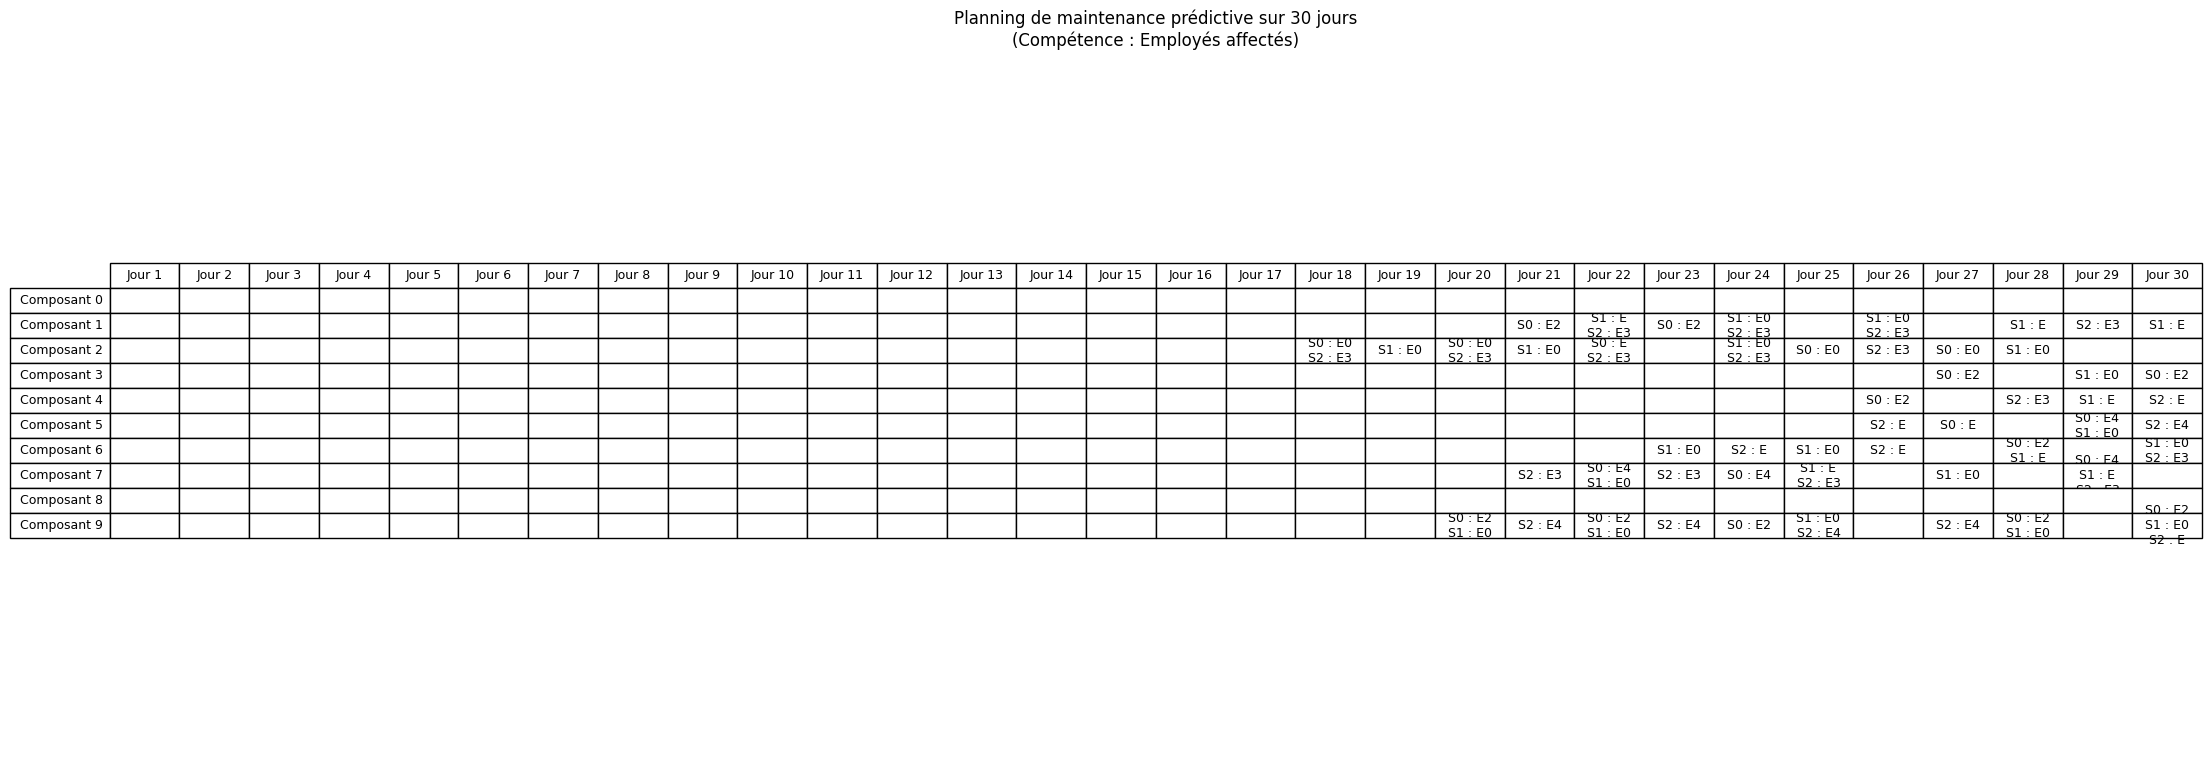

In [9]:
import pulp
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

# --------------------
# Paramètres généraux
# --------------------

components = list(range(10))  # 10 composants
skills = [0, 1, 2]           # 3 compétences : Inspection, Remplacement, Réglage
employees = {
    0: [0, 1],
    1: [1, 2],
    2: [0],
    3: [2],
    4: [0, 2]
}
employees_by_skill = {s: [] for s in skills}
for p, s_list in employees.items():
    for s in s_list:
        employees_by_skill[s].append(p)

# Horizon temporel de 30 jours
days = list(range(30))

# Fixer la graine pour reproductibilité
random.seed(42)

# --------------------
# Génération RUL synthétique sur 30 jours
# --------------------

max_rul = 40
rul = {}
for e in components:
    base = random.randint(20, max_rul)
    for t in days:
        val = max(base - t, 0)
        rul[(e, t)] = val

# Seuil critique RUL pour maintenance obligatoire
D = 3
beta = {}
for e in components:
    for t in days:
        beta[(e, t)] = 1 if rul[(e, t)] <= D else 0

# Disponibilité et panne liées à beta
availability = {}
panne = {}
for e in components:
    for t in days:
        availability[(e, t)] = round(0.8 + 0.2 * (1 - beta[(e, t)]), 2)
        panne[(e, t)] = round(0.05 + 0.3 * beta[(e, t)], 2)

# --------------------
# Données synthétiques réalistes
# --------------------

tau = {}
for e in components:
    for s in skills:
        for p in employees_by_skill[s]:
            base = {0: 1.5, 1: 3.0, 2: 2.0}[s]
            tau[(e, s, p)] = round(random.uniform(base * 0.8, base * 1.2), 2)

phi = {p: 8 for p in employees.keys()}  # 8 heures dispo par jour

hourly_cost = {0: 30, 1: 35, 2: 28, 3: 25, 4: 32}
cost_main = {}
for e in components:
    for s in skills:
        for p in employees_by_skill[s]:
            for t in days:
                cost_main[(e, s, p, t)] = tau[(e, s, p)] * hourly_cost[p]

cost_piece = {}
for e in components:
    for s in skills:
        base_piece = {0: 20, 1: 150, 2: 50}[s]
        for t in days:
            cost_piece[(e, s, t)] = round(random.uniform(base_piece * 0.9, base_piece * 1.1), 2)

N = {(s, t): min(2, len(employees_by_skill[s])) for s in skills for t in days}
alpha = {}
for s in skills:
    for p in employees_by_skill[s]:
        alpha[(s, p)] = 1

M = {}
for s in skills:
    for t in days:
        M[(s, t)] = random.randint(1, 4)

kappa = {}
for e in components:
    for s in skills:
        for r in skills:
            kappa[(e, s, r)] = 1 if s == r else 0

delta = 1  # tolérance en jours

# --------------------
# Construction modèle MILP
# --------------------

model = pulp.LpProblem("Maintenance_Predictive", pulp.LpMinimize)

x = {}
z = {}
for e in components:
    for s in skills:
        for t in days:
            z[(e, s, t)] = pulp.LpVariable(f"z_{e}_{s}_{t}", cat="Binary")
            for p in employees_by_skill[s]:
                x[(e, s, p, t)] = pulp.LpVariable(f"x_{e}_{s}_{p}_{t}", cat="Binary")

model += (
    pulp.lpSum(cost_main[(e, s, p, t)] * x[(e, s, p, t)] for e in components for s in skills for p in employees_by_skill[s] for t in days) +
    pulp.lpSum(cost_piece[(e, s, t)] * z[(e, s, t)] for e in components for s in skills for t in days) -
    10 * pulp.lpSum(availability[(e, t)] for e in components for t in days) +
    20 * pulp.lpSum(panne[(e, t)] for e in components for t in days)
)

for e in components:
    for s in skills:
        for t in days:
            model += pulp.lpSum(alpha[(s, p)] * x[(e, s, p, t)] for p in employees_by_skill[s]) == z[(e, s, t)]

for p in employees.keys():
    for t in days:
        model += pulp.lpSum(tau[(e, s, p)] * x[(e, s, p, t)] for e in components for s in skills if p in employees_by_skill[s]) <= phi[p]

for s in skills:
    for t in days:
        model += pulp.lpSum(x[(e, s, p, t)] for e in components for p in employees_by_skill[s]) <= N[(s, t)]

for e in components:
    for s in skills:
        for t in days:
            if beta[(e, t)] == 1:
                model += pulp.lpSum(z[(e, s, tp)] for tp in range(t, min(t + delta + 1, len(days)))) == 1

for r in skills:
    for t in days:
        model += pulp.lpSum(kappa[(e, s, r)] * z[(e, s, t)] for e in components for s in skills) <= M[(r, t)]

# --------------------
# Résolution
# --------------------

solver = pulp.PULP_CBC_CMD(msg=1)
result = model.solve(solver)
print("Status:", pulp.LpStatus[result])

# --------------------
# Extraction planning
# --------------------

planning = []
for e in components:
    for s in skills:
        for t in days:
            if pulp.value(z[(e, s, t)]) > 0.5:
                affectes = [p for p in employees_by_skill[s] if pulp.value(x[(e, s, p, t)]) > 0.5]
                planning.append({
                    "Composant": e,
                    "Compétence": s,
                    "Jour": t,
                    "Employés affectés": ", ".join(map(str, affectes))
                })
df_plan = pd.DataFrame(planning)
print(df_plan)

# --------------------
# Visualisation planning sous forme de tableau matplotlib
# --------------------

table_data = []
for e in components:
    row = []
    for t in days:
        lignes = df_plan[(df_plan["Composant"] == e) & (df_plan["Jour"] == t)]
        if lignes.empty:
            row.append("")
        else:
            txt = []
            for idx, r in lignes.iterrows():
                txt.append(f"S{r['Compétence']} : E{r['Employés affectés']}")
            row.append("\n".join(txt))
    table_data.append(row)

fig, ax = plt.subplots(figsize=(18, 9))
ax.axis('off')
tbl = ax.table(cellText=table_data,
               rowLabels=[f"Composant {e}" for e in components],
               colLabels=[f"Jour {t+1}" for t in days],
               cellLoc='center',
               loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(9)
tbl.scale(1.5, 1.5)
plt.title("Planning de maintenance prédictive sur 30 jours\n(Compétence : Employés affectés)")
plt.show()


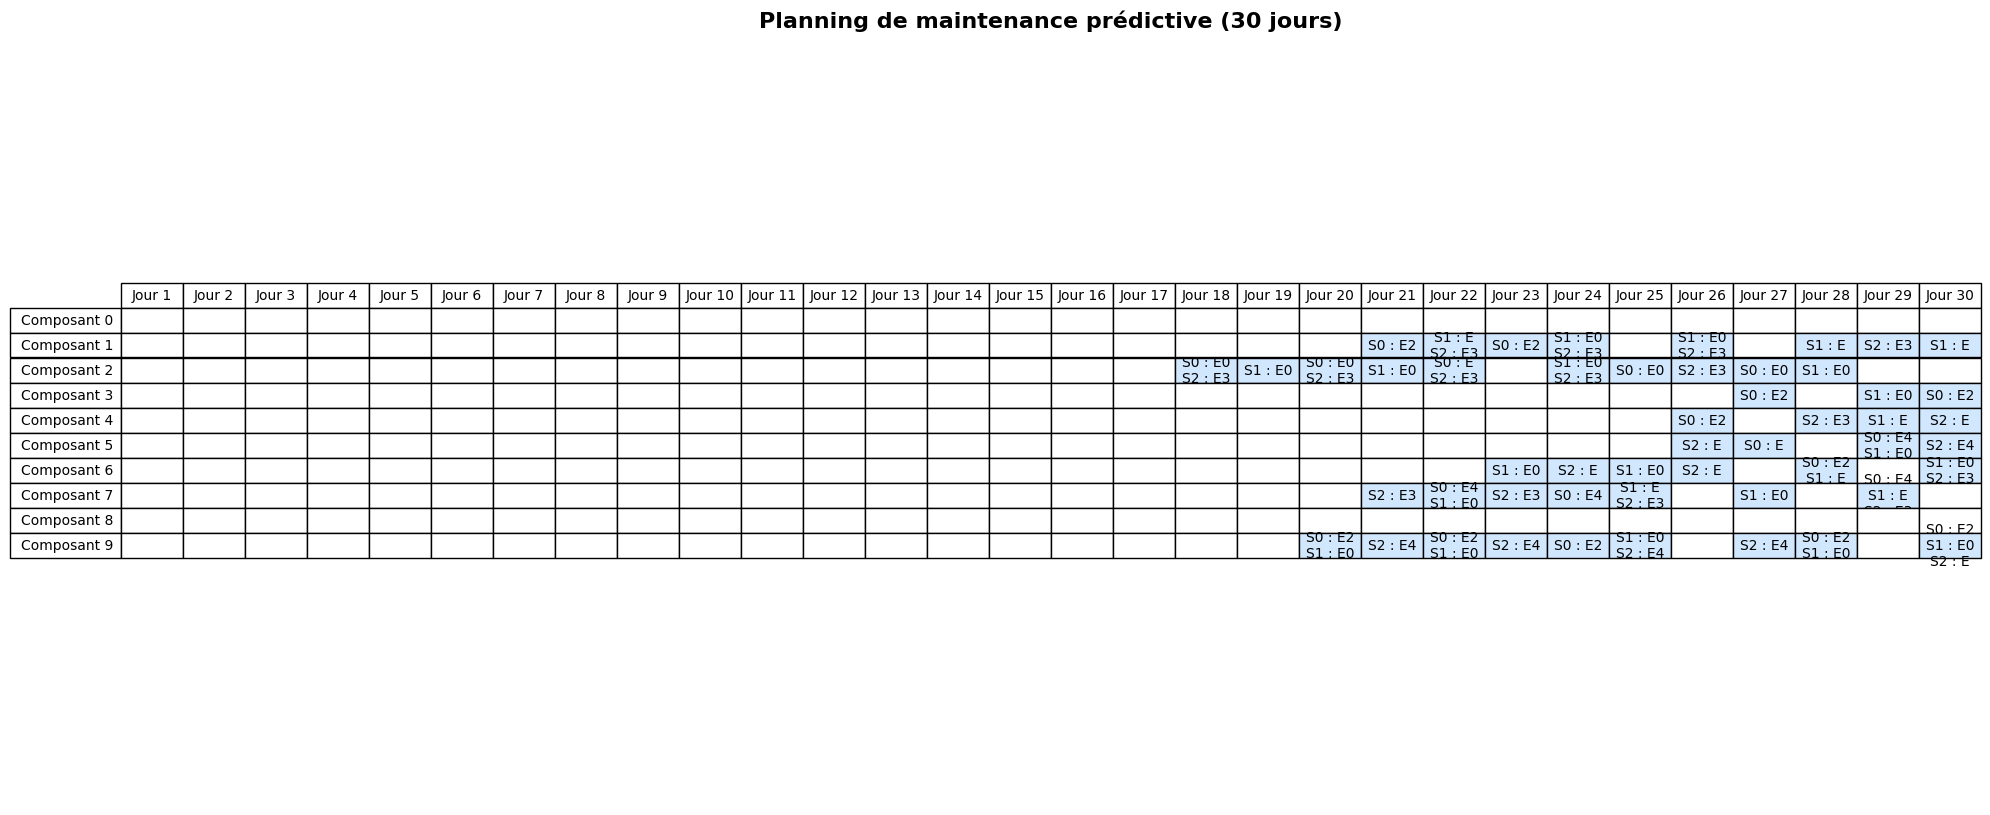

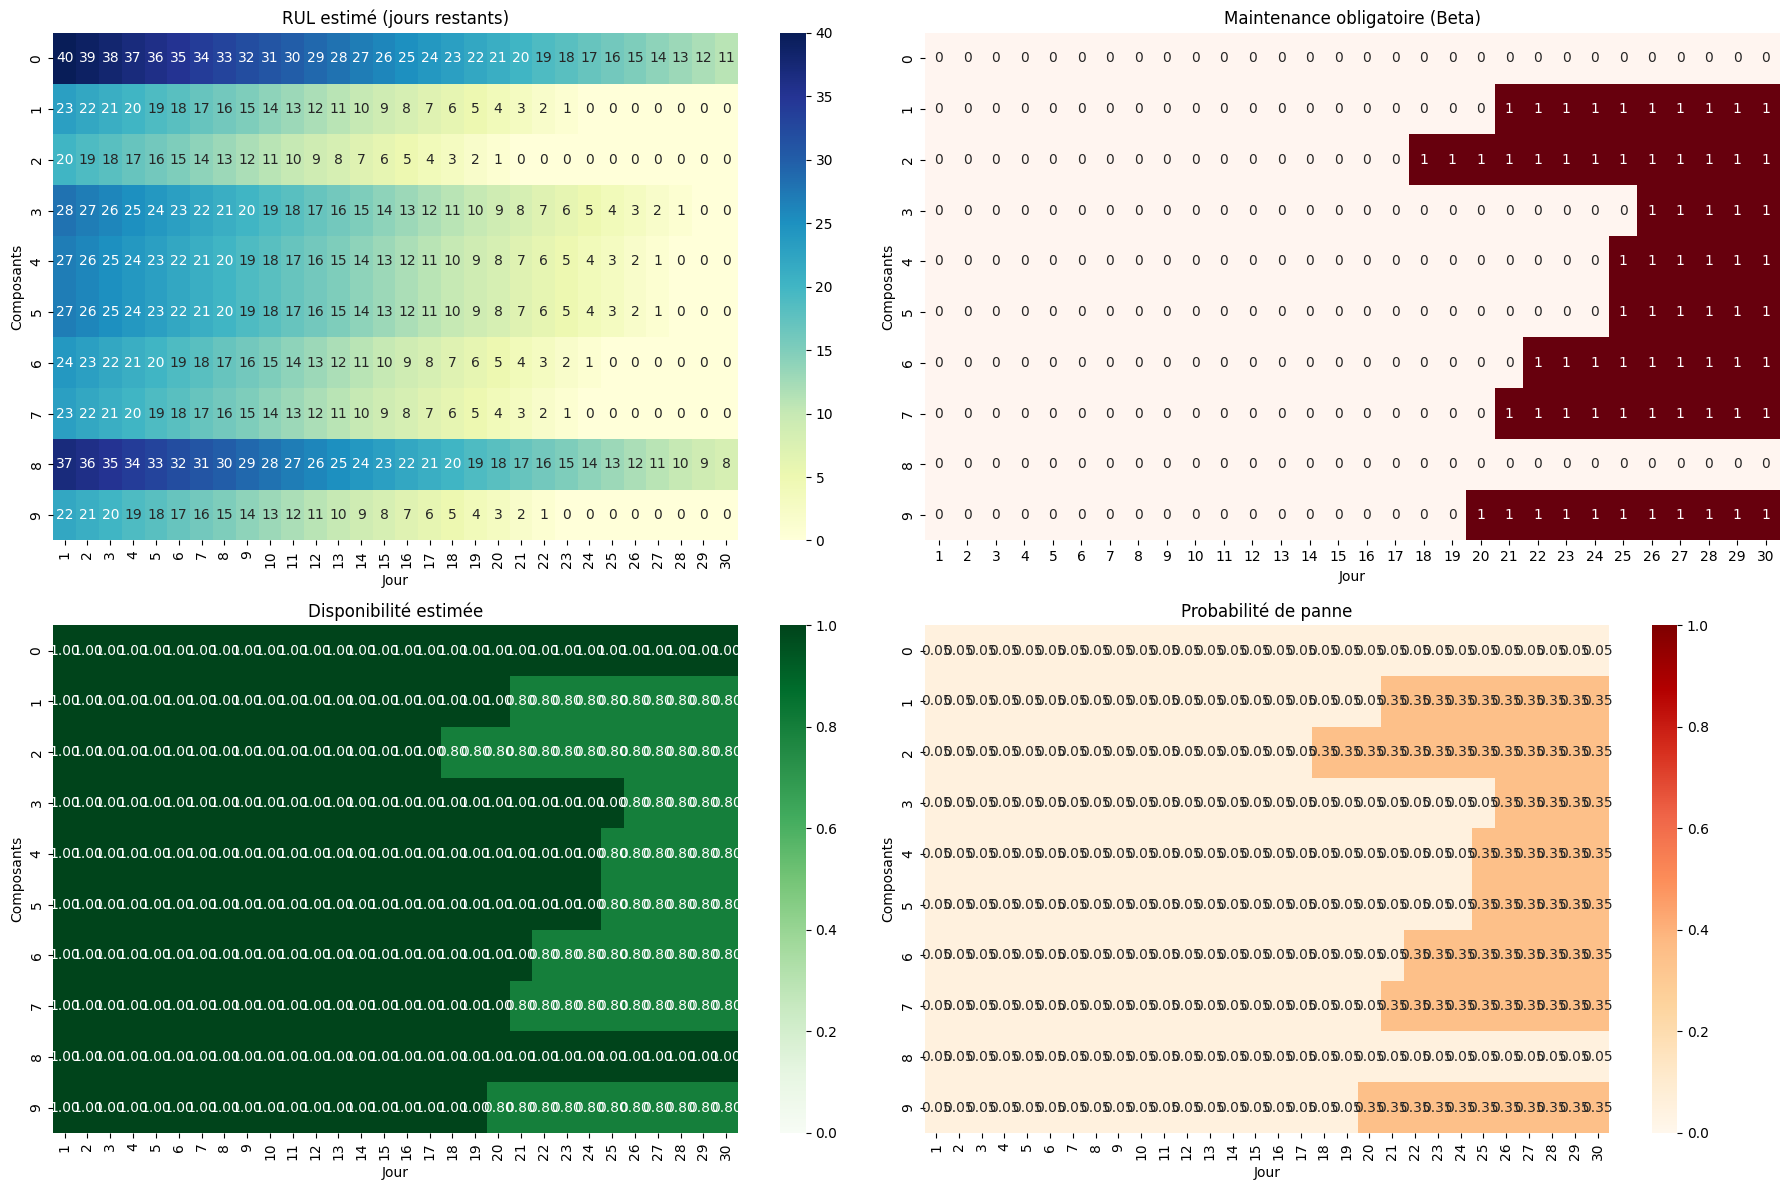

C:\Users\hp\AppData\Local\Temp\ipykernel_6596\2466693733.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emp_ids, y=charges, palette="viridis")


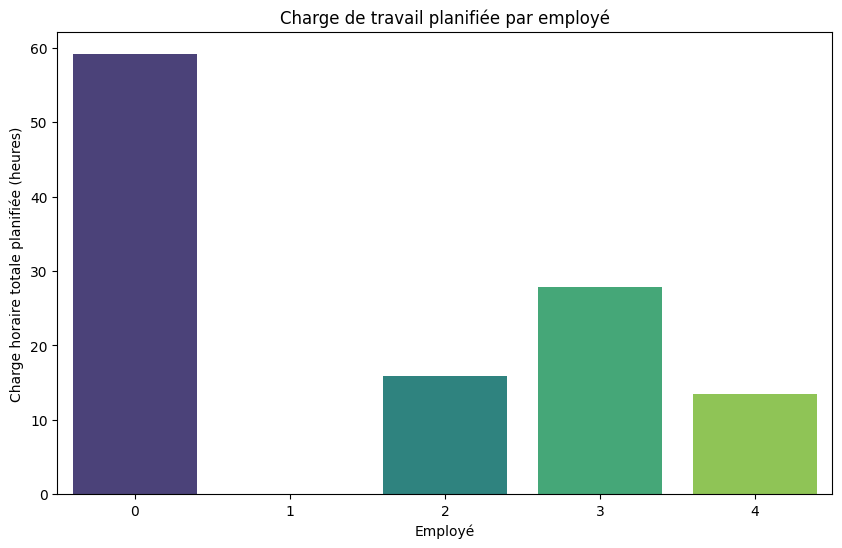

In [10]:
import pulp
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Données et modèle identiques au précédent (pour brevité, on suppose que le modèle est résolu et df_plan est créé) ---

# Après résolution, df_plan contient les colonnes : Composant, Compétence, Jour, Employés affectés

# Pour l’exemple, reprenons components, days, employees etc. de votre dernier script.

# --- Préparation du tableau matplotlib amélioré ---

def plot_planning_table(df_plan, components, days):
    table_data = []
    for e in components:
        row = []
        for t in days:
            lignes = df_plan[(df_plan["Composant"] == e) & (df_plan["Jour"] == t)]
            if lignes.empty:
                row.append("")
            else:
                txt = []
                for _, r in lignes.iterrows():
                    txt.append(f"S{r['Compétence']} : E{r['Employés affectés']}")
                row.append("\n".join(txt))
        table_data.append(row)

    fig, ax = plt.subplots(figsize=(20, 10))
    ax.axis('off')
    table = ax.table(cellText=table_data,
                     rowLabels=[f"Composant {e}" for e in components],
                     colLabels=[f"Jour {t+1}" for t in days],
                     cellLoc='center',
                     loc='center')

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)

    # Coloration conditionnelle : par exemple, cellules avec maintenance en bleu clair
    for i, row in enumerate(table_data):
        for j, cell_text in enumerate(row):
            if cell_text.strip() != "":
                cell = table[i+1, j]
                cell.set_facecolor("#d1e7fd")  # Bleu clair

    plt.title("Planning de maintenance prédictive (30 jours)", fontsize=16, fontweight='bold')
    plt.show()

# --- Heatmaps professionnelles avec seaborn ---

def plot_heatmaps(rul, beta, availability, panne, components, days):
    def dict_to_matrix(d):
        mat = np.zeros((len(components), len(days)))
        for i, e in enumerate(components):
            for j, t in enumerate(days):
                mat[i, j] = d[(e, t)]
        return mat

    rul_mat = dict_to_matrix(rul)
    beta_mat = dict_to_matrix(beta)
    availability_mat = dict_to_matrix(availability)
    panne_mat = dict_to_matrix(panne)

    fig, axs = plt.subplots(2, 2, figsize=(18, 12))
    sns.heatmap(rul_mat, annot=True, fmt=".0f", cmap="YlGnBu", ax=axs[0,0])
    axs[0,0].set_title("RUL estimé (jours restants)")
    axs[0,0].set_ylabel("Composants")
    axs[0,0].set_xlabel("Jour")
    axs[0,0].set_xticklabels([d+1 for d in days])

    sns.heatmap(beta_mat, annot=True, cmap="Reds", cbar=False, ax=axs[0,1], vmin=0, vmax=1)
    axs[0,1].set_title("Maintenance obligatoire (Beta)")
    axs[0,1].set_ylabel("Composants")
    axs[0,1].set_xlabel("Jour")
    axs[0,1].set_xticklabels([d+1 for d in days])

    sns.heatmap(availability_mat, annot=True, fmt=".2f", cmap="Greens", ax=axs[1,0], vmin=0, vmax=1)
    axs[1,0].set_title("Disponibilité estimée")
    axs[1,0].set_ylabel("Composants")
    axs[1,0].set_xlabel("Jour")
    axs[1,0].set_xticklabels([d+1 for d in days])

    sns.heatmap(panne_mat, annot=True, fmt=".2f", cmap="OrRd", ax=axs[1,1], vmin=0, vmax=1)
    axs[1,1].set_title("Probabilité de panne")
    axs[1,1].set_ylabel("Composants")
    axs[1,1].set_xlabel("Jour")
    axs[1,1].set_xticklabels([d+1 for d in days])

    plt.tight_layout()
    plt.show()

# --- Histogramme charge travail employés ---

def plot_workload_histogram(x_vars, components, skills, employees_by_skill, days):
    # Calcul charge horaire totale par employé
    workload = {p: 0 for p in employees_by_skill.keys()}
    workload = {p: 0 for p in sum(employees_by_skill.values(), [])}  # liste unique de tous les employés

    for (e, s, p, t), var in x_vars.items():
        if pulp.value(var) is not None and pulp.value(var) > 0.5:
            workload[p] += tau[(e, s, p)]

    emp_ids = list(workload.keys())
    charges = [workload[p] for p in emp_ids]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=emp_ids, y=charges, palette="viridis")
    plt.xlabel("Employé")
    plt.ylabel("Charge horaire totale planifiée (heures)")
    plt.title("Charge de travail planifiée par employé")
    plt.show()

# --- Utilisation des fonctions ---

# df_plan doit provenir de votre résolution, x est le dict des variables x

plot_planning_table(df_plan, components, days)
plot_heatmaps(rul, beta, availability, panne, components, days)
plot_workload_histogram(x, components, skills, employees_by_skill, days)


In [11]:
# Calcul des coûts main-d’œuvre totaux
total_main_cost = 0
for (e,s,p,t), var in x.items():
    if pulp.value(var) > 0.5:
        total_main_cost += cost_main[(e,s,p,t)]

# Calcul des coûts pièces totaux
total_piece_cost = 0
for (e,s,t), var in z.items():
    if pulp.value(var) > 0.5:
        total_piece_cost += cost_piece[(e,s,t)]

# Sommes disponibilité et pannes
total_availability = sum(availability[(e,t)] for e in components for t in days)
total_panne = sum(panne[(e,t)] for e in components for t in days)

# Coefficients de pondération utilisés dans la fonction objectif
lambda1 = 10
lambda2 = 20

# Coût objectif total final
objective_value = total_main_cost + total_piece_cost - lambda1 * total_availability + lambda2 * total_panne

print(f"Coût total main-d'œuvre : {total_main_cost:.2f} €")
print(f"Coût total pièces : {total_piece_cost:.2f} €")
print(f"Total disponibilité (pondérée négativement) : {-lambda1 * total_availability:.2f}")
print(f"Total pannes (pondérées positivement) : {lambda2 * total_panne:.2f}")
print(f"\nValeur finale de la fonction objectif : {objective_value:.2f} €")


Coût total main-d'œuvre : 3345.65 €
Coût total pièces : 5250.73 €
Total disponibilité (pondérée négativement) : -2860.00
Total pannes (pondérées positivement) : 720.00

Valeur finale de la fonction objectif : 6456.38 €


In [16]:
import pandas as pd

file_path = r"C:\Users\hp\Desktop\PFE UM6P\Code UM6P\Analyse\Oracle - OT-2024-Gantour2.xlsx"

# Liste des feuilles (affichage pour compréhension)
xls = pd.ExcelFile(file_path)
print("Feuilles disponibles :", xls.sheet_names)

# Supposons que la feuille 'Costs' contient les données pertinentes
df_costs = pd.read_excel(file_path, sheet_name='XXOCP___EAM_Transfert_des_ordr_')

print(df_costs.head())

# Exemple d’adaptation selon structure typique :
# Colonnes attendues : ['Composant', 'Competence', 'Employe', 'Jour', 'Duree', 'CoutMain', 'CoutPiece']

# Extraire ensembles uniques
components = df_costs['Composant'].unique()
skills = df_costs['Competence'].unique()
employees = df_costs['Employe'].unique()
days = df_costs['Jour'].unique()

# Construire dictionnaires de coûts et durée
cost_main = {}
cost_piece = {}
tau = {}

for _, row in df_costs.iterrows():
    e = row['Composant']
    s = row['Competence']
    p = row['Employe']
    t = row['Jour']
    cost_main[(e, s, p, t)] = row['CoutMain']
    cost_piece[(e, s, t)] = row['CoutPiece']
    tau[(e, s, p)] = row['Duree']  # supposé constant sur t

# Définir phi (temps dispo par employé) arbitrarily ou charger si dispo
phi = {p: 8 for p in employees}

# Construire alpha(s,p) : 1 si employé p peut faire compétence s (extraction de df ou hypothèse)
alpha = {}
for p in employees:
    for s in skills:
        alpha[(s,p)] = 1  # par défaut, ou affiner selon vos données

# Nbre max employés dispo par compétence et jour, ici simplifié
N = {(s,t): 2 for s in skills for t in days}

# Beta : maintenance obligatoire (à définir, par exemple RUL ou manuel)
beta = {(e,t): 0 for e in components for t in days}  # à adapter

# Stock pièces M, kappa (à définir selon vos données, sinon valeurs par défaut)
M = {(s,t): 10 for s in skills for t in days}
kappa = {(e,s,r): 1 if s==r else 0 for e in components for s in skills for r in skills}

delta = 1  # délai tolérance

# --------- Construction modèle ---------

model = pulp.LpProblem("Minimisation_Couts_Maintenance", pulp.LpMinimize)

x = {}
z = {}

for e in components:
    for s in skills:
        for t in days:
            z[(e,s,t)] = pulp.LpVariable(f"z_{e}_{s}_{t}", cat='Binary')
            for p in employees:
                x[(e,s,p,t)] = pulp.LpVariable(f"x_{e}_{s}_{p}_{t}", cat='Binary')

# Fonction objectif
model += (
    pulp.lpSum(cost_main.get((e,s,p,t), 0) * x[(e,s,p,t)] for e in components for s in skills for p in employees for t in days) +
    pulp.lpSum(cost_piece.get((e,s,t), 0) * z[(e,s,t)] for e in components for s in skills for t in days)
)

# Contraintes principales
for e in components:
    for s in skills:
        for t in days:
            model += pulp.lpSum(alpha.get((s,p),0) * x[(e,s,p,t)] for p in employees) == z[(e,s,t)]

for p in employees:
    for t in days:
        model += pulp.lpSum(tau.get((e,s,p),0) * x[(e,s,p,t)] for e in components for s in skills) <= phi[p]

for s in skills:
    for t in days:
        model += pulp.lpSum(x[(e,s,p,t)] for e in components for p in employees) <= N[(s,t)]

for e in components:
    for s in skills:
        for t in days:
            if beta[(e,t)] == 1:
                model += pulp.lpSum(z[(e,s,tp)] for tp in range(t, min(t+delta+1,len(days)))) == 1

for r in skills:
    for t in days:
        model += pulp.lpSum(kappa[(e,s,r)] * z[(e,s,t)] for e in components for s in skills) <= M[(r,t)]

# Résolution
solver = pulp.PULP_CBC_CMD(msg=1)
result = model.solve()
print("Statut :", pulp.LpStatus[result])

# Extraction planning
planning = []
for e in components:
    for s in skills:
        for t in days:
            if pulp.value(z[(e,s,t)]) > 0.5:
                affectes = [p for p in employees if pulp.value(x[(e,s,p,t)]) > 0.5]
                planning.append({
                    'Composant': e,
                    'Compétence': s,
                    'Jour': t,
                    'Employés affectés': ", ".join(map(str, affectes))
                })

df_plan = pd.DataFrame(planning)
print(df_plan)


Feuilles disponibles : ['XXOCP___EAM_Transfert_des_ordr_']
  Date de fin planifiée  Coût Matière  Coût Main d'oeuvre  \
0   2024-01-02 08:20:00           0.0           30.654504   
1   2024-01-01 08:21:00           0.0           32.161500   
2   2024-01-01 08:51:00           0.0           32.161500   
3   2024-01-02 08:40:00           0.0           15.308874   
4   2024-01-01 09:05:30           0.0          183.780000   

   Coût sous-traitance Planifié  
0                  0.0        Y  
1                  0.0        Y  
2                  0.0        Y  
3                  0.0        Y  
4                  0.0        Y  


KeyError: 'Composant'

In [17]:
import pandas as pd
import numpy as np
import random

# Paramètres
n_composants = 10
n_competences = 3
n_employes = 5
n_jours = 30

composants = [f"C{i+1}" for i in range(n_composants)]
competences = ["Inspection", "Remplacement", "Réglage"]
employes = [f"E{i+1}" for i in range(n_employes)]
jours = list(range(1, n_jours+1))

random.seed(42)
np.random.seed(42)

# Association compétences / employés (un employé peut faire plusieurs compétences)
employe_competences = {
    "E1": ["Inspection", "Remplacement"],
    "E2": ["Remplacement", "Réglage"],
    "E3": ["Inspection"],
    "E4": ["Réglage"],
    "E5": ["Inspection", "Réglage"],
}

# Génération des données
rows = []
for comp in composants:
    for jour in jours:
        # Choisir aléatoirement une compétence requise ce jour (30% chance qu’il y ait maintenance)
        if random.random() < 0.3:
            comp_idx = composants.index(comp)
            jour_idx = jour - 1
            competence = random.choice(competences)
            # Choisir employé pouvant faire cette compétence
            candidats = [e for e, c_list in employe_competences.items() if competence in c_list]
            if len(candidats) == 0:
                continue
            employe = random.choice(candidats)

            # Durée maintenance (heures) selon compétence
            duree = {
                "Inspection": round(np.random.uniform(1.0, 2.0), 2),
                "Remplacement": round(np.random.uniform(2.5, 4.0), 2),
                "Réglage": round(np.random.uniform(1.5, 3.0), 2),
            }[competence]

            # Coût main-d'œuvre = durée * taux horaire (variable par employé)
            taux_horaire = {
                "E1": 30,
                "E2": 35,
                "E3": 28,
                "E4": 25,
                "E5": 32,
            }[employe]
            cout_main = round(duree * taux_horaire, 2)

            # Coût pièces selon compétence
            cout_pieces = {
                "Inspection": round(np.random.uniform(15, 25), 2),
                "Remplacement": round(np.random.uniform(120, 180), 2),
                "Réglage": round(np.random.uniform(40, 60), 2),
            }[competence]

            # Maintenance obligatoire : 1 si jour proche de seuil aléatoire (simulateur RUL)
            maintenance_obligatoire = 1 if random.random() < 0.3 else 0

            rows.append({
                "Composant": comp,
                "Compétence": competence,
                "Employé": employe,
                "Jour": jour,
                "Durée (h)": duree,
                "Coût main-d'œuvre (€)": cout_main,
                "Coût pièces (€)": cout_pieces,
                "Maintenance obligatoire": maintenance_obligatoire
            })

# Création DataFrame
df = pd.DataFrame(rows)

# Afficher aperçu
print(df.head(15))

# Sauvegarde en Excel (optionnel)
df.to_excel("maintenance_data_synthetique.xlsx", index=False)
print("\nFichier 'maintenance_data_synthetique.xlsx' généré.")


   Composant    Compétence Employé  Jour  Durée (h)  Coût main-d'œuvre (€)  \
0         C1  Remplacement      E1     2       3.93                 117.90   
1         C1  Remplacement      E1     6       3.80                 114.00   
2         C1       Réglage      E5     7       1.77                  56.64   
3         C1       Réglage      E5     8       2.42                  77.44   
4         C1       Réglage      E4     9       1.80                  45.00   
5         C1    Inspection      E5    10       1.61                  51.52   
6         C1    Inspection      E3    11       1.30                  36.40   
7         C1    Inspection      E5    15       1.03                  32.96   
8         C1  Remplacement      E1    16       2.78                  83.40   
9         C1    Inspection      E3    22       1.60                  44.80   
10        C1  Remplacement      E1    28       2.91                  87.30   
11        C2       Réglage      E2     1       1.61             

In [23]:
import pandas as pd
import numpy as np
import random
import pulp

# --- 1. Génération des données synthétiques ---

n_composants = 10
n_competences = 3
n_employes = 5
n_jours = 30

composants = [f"C{i+1}" for i in range(n_composants)]
competences = ["Inspection", "Remplacement", "Réglage"]
employes = [f"E{i+1}" for i in range(n_employes)]
jours = list(range(1, n_jours+1))

random.seed(42)
np.random.seed(42)

# Association compétences / employés
employe_competences = {
    "E1": ["Inspection", "Remplacement"],
    "E2": ["Remplacement", "Réglage"],
    "E3": ["Inspection"],
    "E4": ["Réglage"],
    "E5": ["Inspection", "Réglage"],
}

rows = []
for comp in composants:
    for jour in jours:
        if random.random() < 0.3:  # 30% chance d'entretien ce jour
            competence = random.choice(competences)
            candidats = [e for e, cs in employe_competences.items() if competence in cs]
            if not candidats:
                continue
            employe = random.choice(candidats)

            duree = {
                "Inspection": round(np.random.uniform(1.0, 2.0), 2),
                "Remplacement": round(np.random.uniform(2.5, 4.0), 2),
                "Réglage": round(np.random.uniform(1.5, 3.0), 2),
            }[competence]

            taux_horaire = {
                "E1": 30,
                "E2": 35,
                "E3": 28,
                "E4": 25,
                "E5": 32,
            }[employe]

            cout_main = round(duree * taux_horaire, 2)

            cout_pieces = {
                "Inspection": round(np.random.uniform(15, 25), 2),
                "Remplacement": round(np.random.uniform(120, 180), 2),
                "Réglage": round(np.random.uniform(40, 60), 2),
            }[competence]

            maintenance_obligatoire = 1 if random.random() < 0.3 else 0

            rows.append({
                "Composant": comp,
                "Compétence": competence,
                "Employé": employe,
                "Jour": jour,
                "Durée_h": duree,
                "Cout_main_d_oeuvre_Euro": cout_main,
                "Cout_pieces_Euro": cout_pieces,
                "Maintenance_obligatoire": maintenance_obligatoire
            })

df = pd.DataFrame(rows)

# --- 2. Construction du modèle à partir des données synthétiques ---

components = df['Composant'].unique()
skills = df['Compétence'].unique()
employees = df['Employé'].unique()
days = df['Jour'].unique()

# Construire les paramètres
tau = {}
cost_main = {}
cost_piece = {}
for _, row in df.iterrows():
    tau[(row['Composant'], row['Compétence'], row['Employé'])] = row['Durée_h']
    cost_main[(row['Composant'], row['Compétence'], row['Employé'], row['Jour'])] = row['Cout_main_d_oeuvre_Euro']
    cost_piece[(row['Composant'], row['Compétence'], row['Jour'])] = row['Cout_pieces_Euro']

beta = {}
for _, row in df.iterrows():
    beta[(row['Composant'], row['Jour'])] = row['Maintenance_obligatoire']

phi = {p: 8 for p in employees}  # 8h dispo par employé

alpha = {}
for s in skills:
    for p in employees:
        alpha[(s, p)] = 1  # Hypothèse: tout employé peut faire toute compétence (à ajuster si besoin)

N = {(s, t): 2 for s in skills for t in days}  # max 2 employés par compétence et jour

kappa = {}
for e in components:
    for s in skills:
        for r in skills:
            kappa[(e, s, r)] = 1 if s == r else 0

M = {(s, t): 10 for s in skills for t in days}  # stock pièces constant

delta = 1

model = pulp.LpProblem("Minimisation_Couts_Maintenance", pulp.LpMinimize)

x = {}
z = {}
for e in components:
    for s in skills:
        for t in days:
            z[(e, s, t)] = pulp.LpVariable(f"z_{e}_{s}_{t}", cat='Binary')
            for p in employees:
                x[(e, s, p, t)] = pulp.LpVariable(f"x_{e}_{s}_{p}_{t}", cat='Binary')

model += (
    pulp.lpSum(cost_main.get((e, s, p, t), 0) * x[(e, s, p, t)] for e in components for s in skills for p in employees for t in days) +
    pulp.lpSum(cost_piece.get((e, s, t), 0) * z[(e, s, t)] for e in components for s in skills for t in days)
)

for e in components:
    for s in skills:
        for t in days:
            model += pulp.lpSum(alpha.get((s, p), 0) * x[(e, s, p, t)] for p in employees) == z[(e, s, t)]

for p in employees:
    for t in days:
        model += pulp.lpSum(tau.get((e, s, p), 0) * x[(e, s, p, t)] for e in components for s in skills) <= phi[p]

for s in skills:
    for t in days:
        model += pulp.lpSum(x[(e, s, p, t)] for e in components for p in employees) <= N[(s, t)]

for e in components:
    for s in skills:
        for t in days:
            if beta.get((e, t), 0) == 1:
                model += pulp.lpSum(z[(e, s, tp)] for tp in range(t, min(t + delta + 1, len(days)))) == 1

for r in skills:
    for t in days:
        model += pulp.lpSum(kappa[(e, s, r)] * z[(e, s, t)] for e in components for s in skills) <= M[(r, t)]

solver = pulp.PULP_CBC_CMD(msg=1)
result = model.solve()
print(f"Statut de la résolution : {pulp.LpStatus[result]}")

# --- 3. Extraction et affichage du planning ---

planning = []
for e in components:
    for s in skills:
        for t in days:
            if pulp.value(z[(e, s, t)]) > 0.5:
                affectes = [p for p in employees if pulp.value(x[(e, s, p, t)]) > 0.5]
                planning.append({
                    "Composant": e,
                    "Compétence": s,
                    "Jour": t,
                    "Employés affectés": ", ".join(affectes)
                })

df_plan = pd.DataFrame(planning)
print(df_plan)


Statut de la résolution : Infeasible
   Composant    Compétence  Jour Employés affectés
0         C1  Remplacement     7                E1
1         C1  Remplacement    11                E1
2         C1  Remplacement     3                E1
3         C1       Réglage     2                E2
4         C1       Réglage     6                E2
..       ...           ...   ...               ...
58        C7    Inspection    22                E1
59        C7    Inspection     3                E1
60        C9  Remplacement    16                E1
61        C9       Réglage    16                E2
62        C9    Inspection    17                E2

[63 rows x 4 columns]


Statut de la résolution : Infeasible
   Composant    Compétence  Jour Employés affectés
46        C6       Réglage     1                E2
3         C1       Réglage     2                E2
17        C2    Inspection     2                E1
49        C6    Inspection     2                E1
44        C6  Remplacement     2                E1
..       ...           ...   ...               ...
29        C3       Réglage    25                E1
34        C3    Inspection    26                E2
33        C3    Inspection    29                E1
23        C3  Remplacement    29                E1
28        C3       Réglage    29                E1

[63 rows x 4 columns]


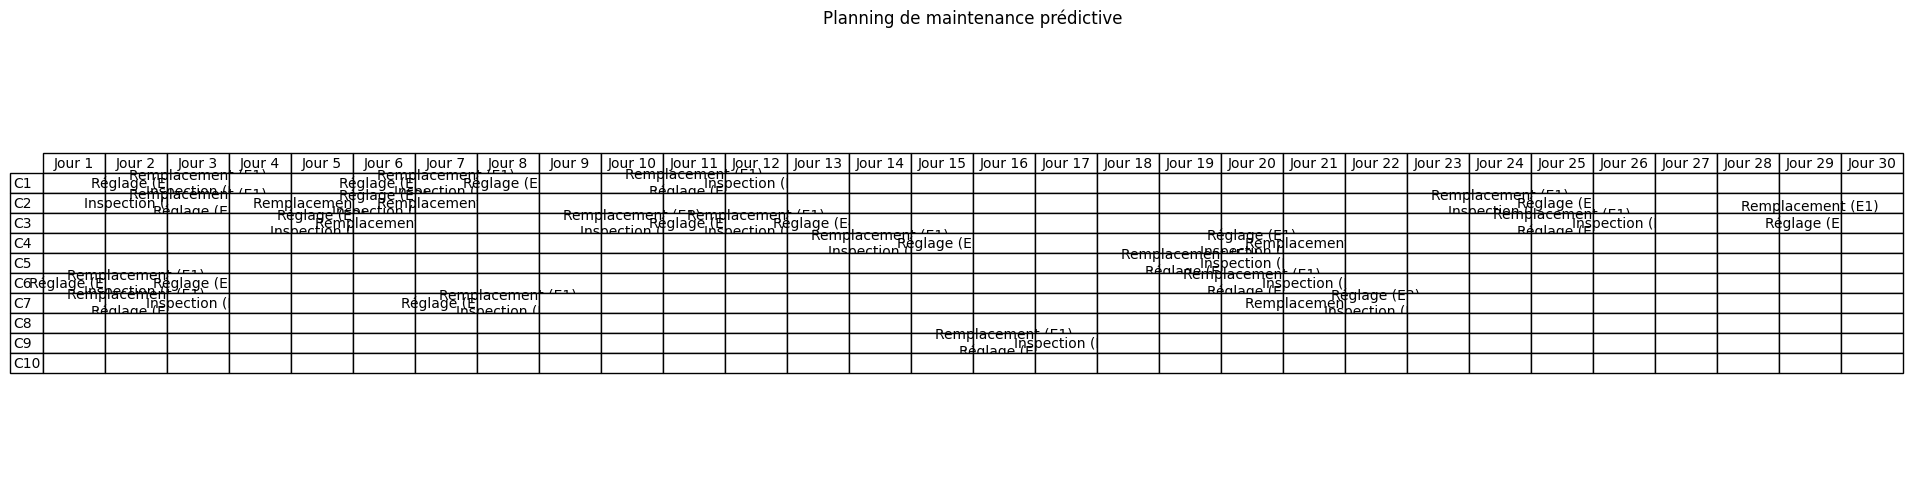

In [24]:
import pandas as pd
import numpy as np
import random
import pulp
import matplotlib.pyplot as plt

# --- 1. Génération des données synthétiques ---

n_composants = 10
n_competences = 3
n_employes = 5
n_jours = 30

composants = [f"C{i+1}" for i in range(n_composants)]
competences = ["Inspection", "Remplacement", "Réglage"]
employes = [f"E{i+1}" for i in range(n_employes)]
jours = list(range(1, n_jours + 1))

random.seed(42)
np.random.seed(42)

# Association compétences / employés
employe_competences = {
    "E1": ["Inspection", "Remplacement"],
    "E2": ["Remplacement", "Réglage"],
    "E3": ["Inspection"],
    "E4": ["Réglage"],
    "E5": ["Inspection", "Réglage"],
}

rows = []
for comp in composants:
    for jour in jours:
        if random.random() < 0.3:  # 30% chance d'entretien ce jour
            competence = random.choice(competences)
            candidats = [e for e, cs in employe_competences.items() if competence in cs]
            if not candidats:
                continue
            employe = random.choice(candidats)

            duree = {
                "Inspection": round(np.random.uniform(1.0, 2.0), 2),
                "Remplacement": round(np.random.uniform(2.5, 4.0), 2),
                "Réglage": round(np.random.uniform(1.5, 3.0), 2),
            }[competence]

            taux_horaire = {
                "E1": 30,
                "E2": 35,
                "E3": 28,
                "E4": 25,
                "E5": 32,
            }[employe]

            cout_main = round(duree * taux_horaire, 2)

            cout_pieces = {
                "Inspection": round(np.random.uniform(15, 25), 2),
                "Remplacement": round(np.random.uniform(120, 180), 2),
                "Réglage": round(np.random.uniform(40, 60), 2),
            }[competence]

            maintenance_obligatoire = 1 if random.random() < 0.3 else 0

            rows.append({
                "Composant": comp,
                "Compétence": competence,
                "Employé": employe,
                "Jour": jour,
                "Durée_h": duree,
                "Cout_main_d_oeuvre_Euro": cout_main,
                "Cout_pieces_Euro": cout_pieces,
                "Maintenance_obligatoire": maintenance_obligatoire
            })

df = pd.DataFrame(rows)

# --- 2. Construction du modèle à partir des données synthétiques ---

components = df['Composant'].unique()
skills = df['Compétence'].unique()
employees = df['Employé'].unique()
days = df['Jour'].unique()

# Construire les paramètres
tau = {}
cost_main = {}
cost_piece = {}
for _, row in df.iterrows():
    tau[(row['Composant'], row['Compétence'], row['Employé'])] = row['Durée_h']
    cost_main[(row['Composant'], row['Compétence'], row['Employé'], row['Jour'])] = row['Cout_main_d_oeuvre_Euro']
    cost_piece[(row['Composant'], row['Compétence'], row['Jour'])] = row['Cout_pieces_Euro']

beta = {}
for _, row in df.iterrows():
    beta[(row['Composant'], row['Jour'])] = row['Maintenance_obligatoire']

phi = {p: 8 for p in employees}  # 8h dispo par employé

alpha = {}
for s in skills:
    for p in employees:
        alpha[(s, p)] = 1  # Hypothèse: tout employé peut faire toute compétence (à ajuster si besoin)

N = {(s, t): 2 for s in skills for t in days}  # max 2 employés par compétence et jour

kappa = {}
for e in components:
    for s in skills:
        for r in skills:
            kappa[(e, s, r)] = 1 if s == r else 0

M = {(s, t): 10 for s in skills for t in days}  # stock pièces constant

delta = 1

model = pulp.LpProblem("Minimisation_Couts_Maintenance", pulp.LpMinimize)

x = {}
z = {}
for e in components:
    for s in skills:
        for t in days:
            z[(e, s, t)] = pulp.LpVariable(f"z_{e}_{s}_{t}", cat='Binary')
            for p in employees:
                x[(e, s, p, t)] = pulp.LpVariable(f"x_{e}_{s}_{p}_{t}", cat='Binary')

model += (
    pulp.lpSum(cost_main.get((e, s, p, t), 0) * x[(e, s, p, t)] for e in components for s in skills for p in employees for t in days) +
    pulp.lpSum(cost_piece.get((e, s, t), 0) * z[(e, s, t)] for e in components for s in skills for t in days)
)

for e in components:
    for s in skills:
        for t in days:
            model += pulp.lpSum(alpha.get((s, p), 0) * x[(e, s, p, t)] for p in employees) == z[(e, s, t)]

for p in employees:
    for t in days:
        model += pulp.lpSum(tau.get((e, s, p), 0) * x[(e, s, p, t)] for e in components for s in skills) <= phi[p]

for s in skills:
    for t in days:
        model += pulp.lpSum(x[(e, s, p, t)] for e in components for p in employees) <= N[(s, t)]

for e in components:
    for s in skills:
        for t in days:
            if beta.get((e, t), 0) == 1:
                model += pulp.lpSum(z[(e, s, tp)] for tp in range(t, min(t + delta + 1, len(days)))) == 1

for r in skills:
    for t in days:
        model += pulp.lpSum(kappa[(e, s, r)] * z[(e, s, t)] for e in components for s in skills) <= M[(r, t)]

solver = pulp.PULP_CBC_CMD(msg=1)
result = model.solve()
print(f"Statut de la résolution : {pulp.LpStatus[result]}")

# --- 3. Extraction et affichage du planning ---

planning = []
for e in components:
    for s in skills:
        for t in days:
            if pulp.value(z[(e, s, t)]) > 0.5:
                affectes = [p for p in employees if pulp.value(x[(e, s, p, t)]) > 0.5]
                planning.append({
                    "Composant": e,
                    "Compétence": s,
                    "Jour": t,
                    "Employés affectés": ", ".join(affectes)
                })

df_plan = pd.DataFrame(planning)

# Affichage simple trié
print(df_plan.sort_values(by=["Jour", "Composant", "Compétence"]))

# --- 4. Affichage graphique du planning ---

table_data = []
for c in composants:
    row = []
    for d in jours:
        lignes = df_plan[(df_plan['Composant'] == c) & (df_plan['Jour'] == d)]
        if lignes.empty:
            row.append("")
        else:
            txt = []
            for _, r in lignes.iterrows():
                txt.append(f"{r['Compétence']} ({r['Employés affectés']})")
            row.append("\n".join(txt))
    table_data.append(row)

fig, ax = plt.subplots(figsize=(20, len(composants)*0.6))
ax.axis('off')
table = ax.table(cellText=table_data,
                 rowLabels=composants,
                 colLabels=[f"Jour {j}" for j in jours],
                 cellLoc='center',
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.title("Planning de maintenance prédictive")
plt.show()


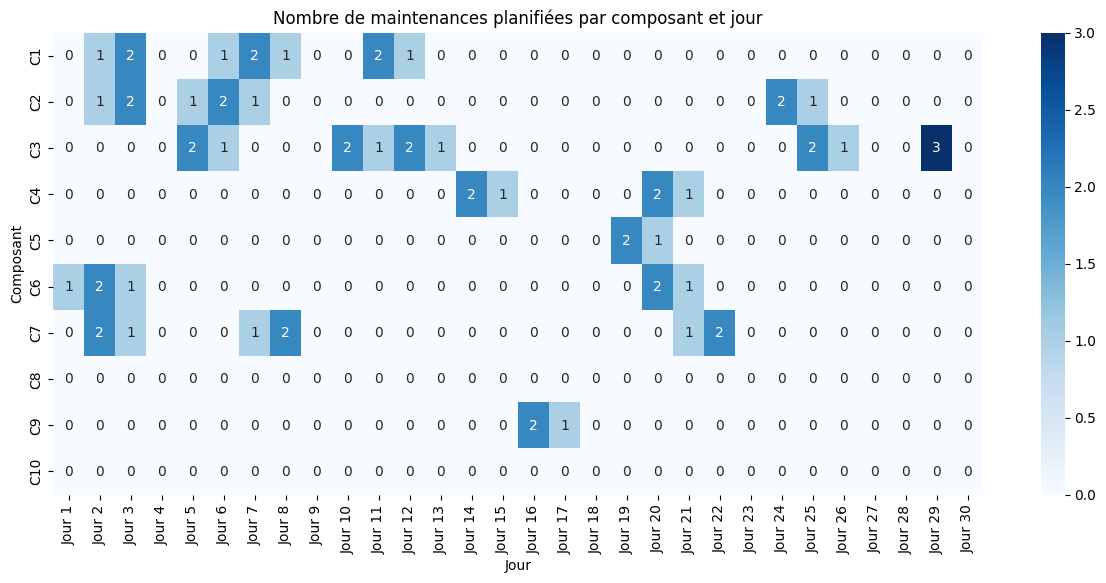

C:\Users\hp\AppData\Local\Temp\ipykernel_6596\1929130295.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(charge_emp.keys()), y=list(charge_emp.values()), palette="viridis")


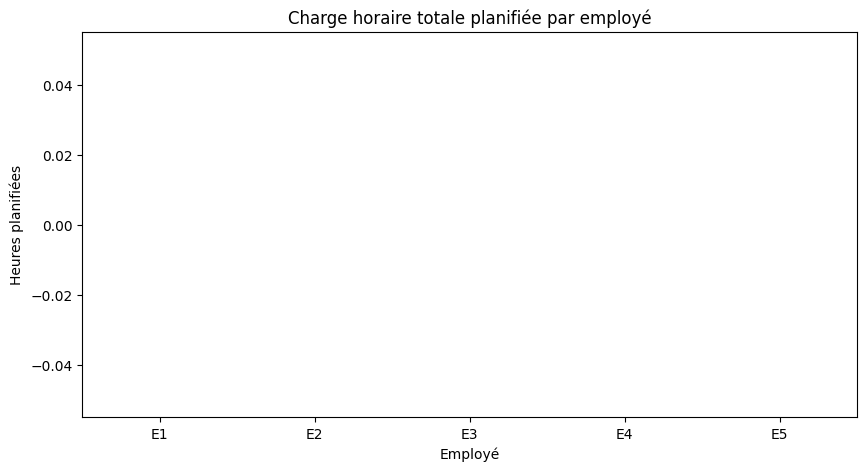

IndexError: index 0 is out of bounds for axis 0 with size 0

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Heatmap maintenances planifiées (z variables) ---

# Matrice composant x jour = nombre de maintenances (compétences confondues)
import numpy as np

mat = np.zeros((len(composants), len(jours)))

for idx_c, c in enumerate(composants):
    for idx_d, d in enumerate(jours):
        count = df_plan[(df_plan['Composant'] == c) & (df_plan['Jour'] == d)].shape[0]
        mat[idx_c, idx_d] = count

plt.figure(figsize=(15, 6))
sns.heatmap(mat, annot=True, fmt=".0f", cmap="Blues",
            xticklabels=[f"Jour {j}" for j in jours],
            yticklabels=composants)
plt.title("Nombre de maintenances planifiées par composant et jour")
plt.xlabel("Jour")
plt.ylabel("Composant")
plt.show()

# --- 2. Histogramme charge horaire par employé ---

# Calcul charge totale (durée) par employé
charge_emp = {p:0 for p in employes}
for _, row in df_plan.iterrows():
    p_list = row['Employés affectés'].split(", ")
    duree = df[(df['Composant'] == row['Composant']) & (df['Compétence'] == row['Compétence']) & (df['Employé'].isin(p_list))]['Durée_h'].mean()
    for p in p_list:
        charge_emp[p] += duree if duree else 0

plt.figure(figsize=(10,5))
sns.barplot(x=list(charge_emp.keys()), y=list(charge_emp.values()), palette="viridis")
plt.title("Charge horaire totale planifiée par employé")
plt.xlabel("Employé")
plt.ylabel("Heures planifiées")
plt.show()

# --- 3. Diagramme des coûts totaux par jour ---

# Somme des coûts main+pièces par jour
couts_jours = df_plan.groupby('Jour').apply(
    lambda group: group.apply(
        lambda r: df[(df['Composant']==r['Composant']) & 
                     (df['Compétence']==r['Compétence']) & 
                     (df['Jour']==r['Jour'])]['Cout_main_d_oeuvre_Euro'].values[0] +
                  df[(df['Composant']==r['Composant']) & 
                     (df['Compétence']==r['Compétence']) & 
                     (df['Jour']==r['Jour'])]['Cout_pieces_Euro'].values[0], axis=1
    ).sum()
)

plt.figure(figsize=(12,6))
sns.lineplot(x=couts_jours.index, y=couts_jours.values, marker="o")
plt.title("Coût total des maintenances planifiées par jour")
plt.xlabel("Jour")
plt.ylabel("Coût total (€)")
plt.show()


Statut de la résolution : Infeasible
   Composant    Compétence  Jour Employés affectés
46        C6       Réglage     1                E2
3         C1       Réglage     2                E2
17        C2    Inspection     2                E1
49        C6    Inspection     2                E1
44        C6  Remplacement     2                E1
..       ...           ...   ...               ...
29        C3       Réglage    25                E1
34        C3    Inspection    26                E2
33        C3    Inspection    29                E1
23        C3  Remplacement    29                E1
28        C3       Réglage    29                E1

[63 rows x 4 columns]


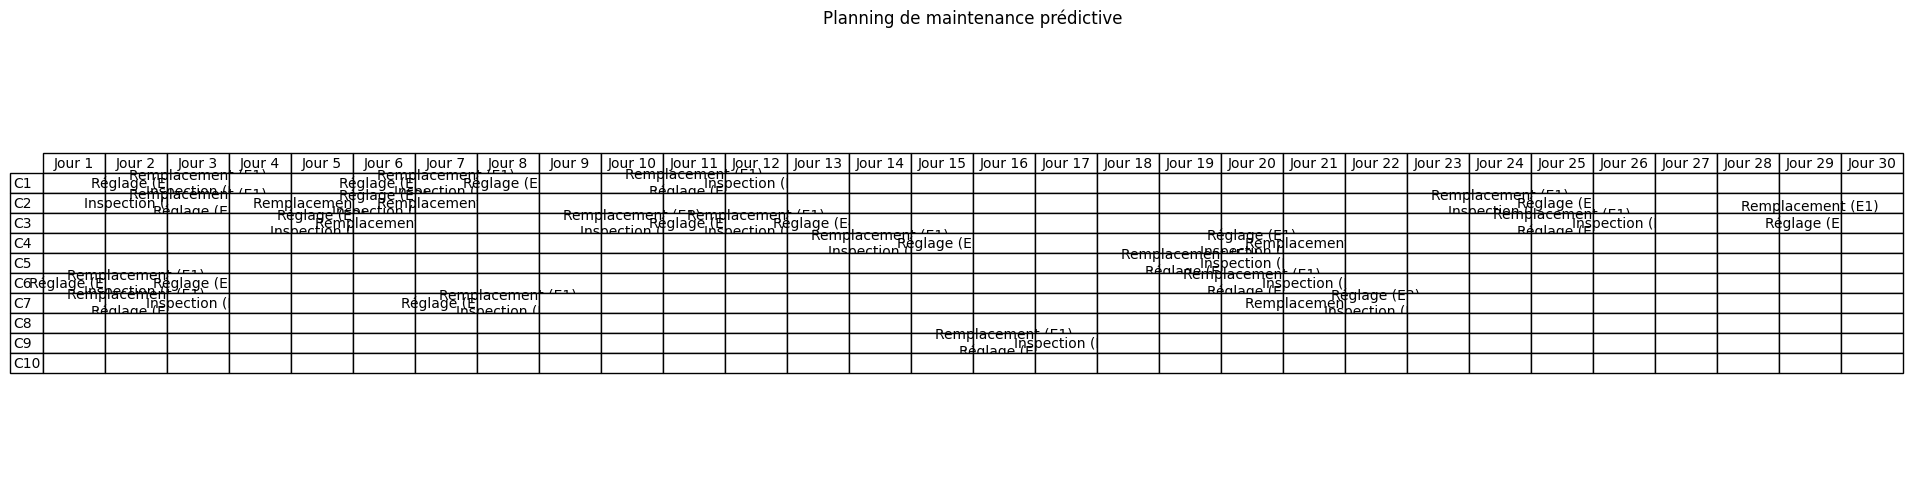

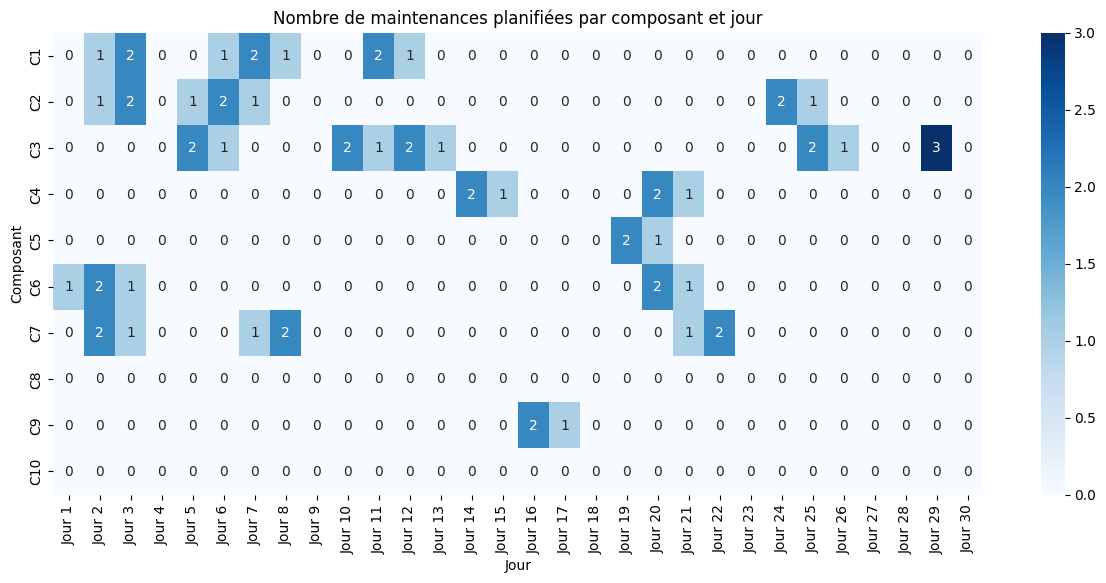

C:\Users\hp\AppData\Local\Temp\ipykernel_6596\2448442696.py:237: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(charge_emp.keys()), y=list(charge_emp.values()), palette="viridis")


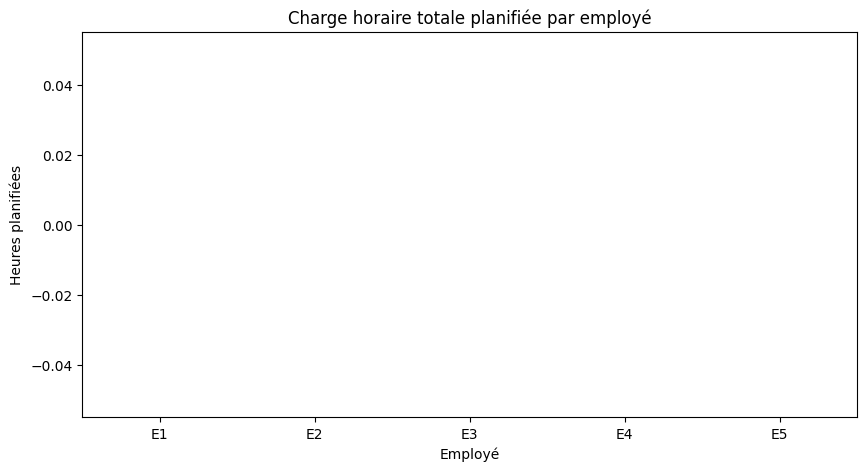

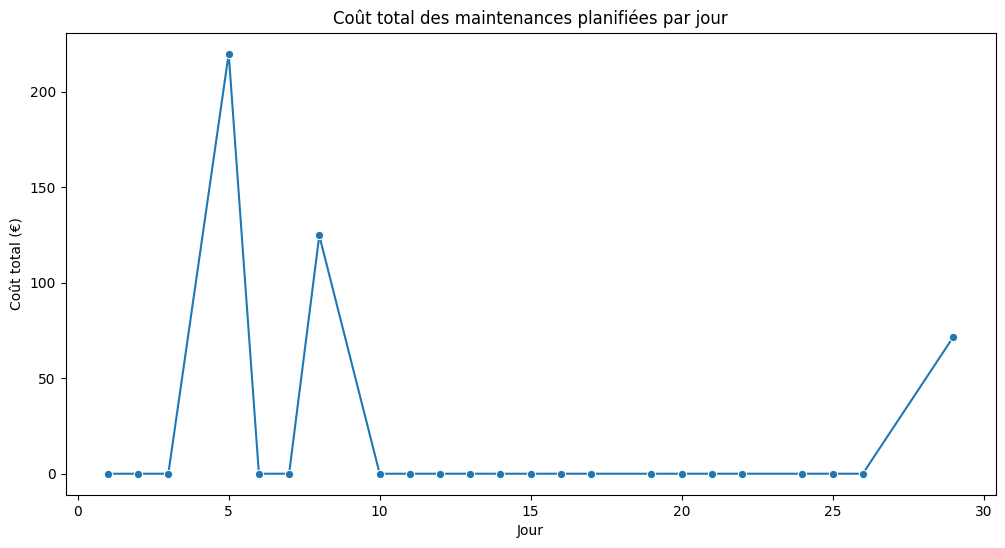

In [26]:
import pandas as pd
import numpy as np
import random
import pulp
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Génération des données synthétiques ---

n_composants = 10
n_competences = 3
n_employes = 5
n_jours = 30

composants = [f"C{i+1}" for i in range(n_composants)]
competences = ["Inspection", "Remplacement", "Réglage"]
employes = [f"E{i+1}" for i in range(n_employes)]
jours = list(range(1, n_jours + 1))

random.seed(42)
np.random.seed(42)

# Association compétences / employés
employe_competences = {
    "E1": ["Inspection", "Remplacement"],
    "E2": ["Remplacement", "Réglage"],
    "E3": ["Inspection"],
    "E4": ["Réglage"],
    "E5": ["Inspection", "Réglage"],
}

rows = []
for comp in composants:
    for jour in jours:
        if random.random() < 0.3:  # 30% chance d'entretien ce jour
            competence = random.choice(competences)
            candidats = [e for e, cs in employe_competences.items() if competence in cs]
            if not candidats:
                continue
            employe = random.choice(candidats)

            duree = {
                "Inspection": round(np.random.uniform(1.0, 2.0), 2),
                "Remplacement": round(np.random.uniform(2.5, 4.0), 2),
                "Réglage": round(np.random.uniform(1.5, 3.0), 2),
            }[competence]

            taux_horaire = {
                "E1": 30,
                "E2": 35,
                "E3": 28,
                "E4": 25,
                "E5": 32,
            }[employe]

            cout_main = round(duree * taux_horaire, 2)

            cout_pieces = {
                "Inspection": round(np.random.uniform(15, 25), 2),
                "Remplacement": round(np.random.uniform(120, 180), 2),
                "Réglage": round(np.random.uniform(40, 60), 2),
            }[competence]

            maintenance_obligatoire = 1 if random.random() < 0.3 else 0

            rows.append({
                "Composant": comp,
                "Compétence": competence,
                "Employé": employe,
                "Jour": jour,
                "Durée_h": duree,
                "Cout_main_d_oeuvre_Euro": cout_main,
                "Cout_pieces_Euro": cout_pieces,
                "Maintenance_obligatoire": maintenance_obligatoire
            })

df = pd.DataFrame(rows)

# --- 2. Construction du modèle à partir des données synthétiques ---

components = df['Composant'].unique()
skills = df['Compétence'].unique()
employees = df['Employé'].unique()
days = df['Jour'].unique()

tau = {}
cost_main = {}
cost_piece = {}
for _, row in df.iterrows():
    tau[(row['Composant'], row['Compétence'], row['Employé'])] = row['Durée_h']
    cost_main[(row['Composant'], row['Compétence'], row['Employé'], row['Jour'])] = row['Cout_main_d_oeuvre_Euro']
    cost_piece[(row['Composant'], row['Compétence'], row['Jour'])] = row['Cout_pieces_Euro']

beta = {}
for _, row in df.iterrows():
    beta[(row['Composant'], row['Jour'])] = row['Maintenance_obligatoire']

phi = {p: 8 for p in employees}

alpha = {}
for s in skills:
    for p in employees:
        alpha[(s, p)] = 1

N = {(s, t): 2 for s in skills for t in days}

kappa = {}
for e in components:
    for s in skills:
        for r in skills:
            kappa[(e, s, r)] = 1 if s == r else 0

M = {(s, t): 10 for s in skills for t in days}

delta = 1

model = pulp.LpProblem("Minimisation_Couts_Maintenance", pulp.LpMinimize)

x = {}
z = {}
for e in components:
    for s in skills:
        for t in days:
            z[(e, s, t)] = pulp.LpVariable(f"z_{e}_{s}_{t}", cat='Binary')
            for p in employees:
                x[(e, s, p, t)] = pulp.LpVariable(f"x_{e}_{s}_{p}_{t}", cat='Binary')

model += (
    pulp.lpSum(cost_main.get((e, s, p, t), 0) * x[(e, s, p, t)]
               for e in components for s in skills for p in employees for t in days) +
    pulp.lpSum(cost_piece.get((e, s, t), 0) * z[(e, s, t)]
               for e in components for s in skills for t in days)
)

for e in components:
    for s in skills:
        for t in days:
            model += pulp.lpSum(alpha.get((s, p), 0) * x[(e, s, p, t)] for p in employees) == z[(e, s, t)]

for p in employees:
    for t in days:
        model += pulp.lpSum(tau.get((e, s, p), 0) * x[(e, s, p, t)] for e in components for s in skills) <= phi[p]

for s in skills:
    for t in days:
        model += pulp.lpSum(x[(e, s, p, t)] for e in components for p in employees) <= N[(s, t)]

for e in components:
    for s in skills:
        for t in days:
            if beta.get((e, t), 0) == 1:
                model += pulp.lpSum(z[(e, s, tp)] for tp in range(t, min(t + delta + 1, len(days)))) == 1

for r in skills:
    for t in days:
        model += pulp.lpSum(kappa[(e, s, r)] * z[(e, s, t)] for e in components for s in skills) <= M[(r, t)]

solver = pulp.PULP_CBC_CMD(msg=1)
result = model.solve()
print("Statut de la résolution :", pulp.LpStatus[result])

# --- 3. Extraction et affichage du planning ---

planning = []
for e in components:
    for s in skills:
        for t in days:
            if pulp.value(z[(e, s, t)]) > 0.5:
                affectes = [p for p in employees if pulp.value(x[(e, s, p, t)]) > 0.5]
                planning.append({
                    "Composant": e,
                    "Compétence": s,
                    "Jour": t,
                    "Employés affectés": ", ".join(affectes)
                })

df_plan = pd.DataFrame(planning)
print(df_plan.sort_values(by=["Jour", "Composant", "Compétence"]))

# --- 4. Affichage graphique du planning ---

table_data = []
for c in composants:
    row = []
    for d in jours:
        lignes = df_plan[(df_plan['Composant'] == c) & (df_plan['Jour'] == d)]
        if lignes.empty:
            row.append("")
        else:
            txt = []
            for _, r in lignes.iterrows():
                txt.append(f"{r['Compétence']} ({r['Employés affectés']})")
            row.append("\n".join(txt))
    table_data.append(row)

fig, ax = plt.subplots(figsize=(20, len(composants)*0.6))
ax.axis('off')
table = ax.table(cellText=table_data,
                 rowLabels=composants,
                 colLabels=[f"Jour {j}" for j in jours],
                 cellLoc='center',
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.title("Planning de maintenance prédictive")
plt.show()

# --- 5. Visualisations complémentaires ---

# Heatmap maintenances planifiées par composant et jour
mat = np.zeros((len(composants), len(jours)))
for idx_c, c in enumerate(composants):
    for idx_d, d in enumerate(jours):
        mat[idx_c, idx_d] = df_plan[(df_plan['Composant'] == c) & (df_plan['Jour'] == d)].shape[0]

plt.figure(figsize=(15, 6))
sns.heatmap(mat, annot=True, fmt=".0f", cmap="Blues",
            xticklabels=[f"Jour {j}" for j in jours],
            yticklabels=composants)
plt.title("Nombre de maintenances planifiées par composant et jour")
plt.xlabel("Jour")
plt.ylabel("Composant")
plt.show()

# Histogramme charge horaire par employé
charge_emp = {p: 0 for p in employes}
for _, row in df_plan.iterrows():
    p_list = row['Employés affectés'].split(", ")
    duree = df[(df['Composant'] == row['Composant']) & 
               (df['Compétence'] == row['Compétence']) & 
               (df['Employé'].isin(p_list))]['Durée_h'].mean()
    for p in p_list:
        charge_emp[p] += duree if duree else 0

plt.figure(figsize=(10, 5))
sns.barplot(x=list(charge_emp.keys()), y=list(charge_emp.values()), palette="viridis")
plt.title("Charge horaire totale planifiée par employé")
plt.xlabel("Employé")
plt.ylabel("Heures planifiées")
plt.show()

# Diagramme des coûts totaux par jour
df_merged = pd.merge(df_plan, df, on=['Composant', 'Compétence', 'Jour'], how='left')
df_merged['Cout_total'] = df_merged['Cout_main_d_oeuvre_Euro'].fillna(0) + df_merged['Cout_pieces_Euro'].fillna(0)

couts_jours = df_merged.groupby('Jour')['Cout_total'].sum()

plt.figure(figsize=(12, 6))
sns.lineplot(x=couts_jours.index, y=couts_jours.values, marker="o")
plt.title("Coût total des maintenances planifiées par jour")
plt.xlabel("Jour")
plt.ylabel("Coût total (€)")
plt.show()


In [29]:
import random
import pandas as pd

# Paramètres
random.seed(42)  # pour reproductibilité

components = [f"C{i}" for i in range(1, 11)]
skills = ["Meca", "Elec", "Hydrau"]
employees = ["P1", "P2", "P3", "P4"]
days = list(range(1, 6))

phi = {p: 8 for p in employees}  # max 8h/jour travail par employé
delta = {c: random.randint(1, 2) for c in components}  # fenêtre tolérance

# Compétences des employés (alpha)
alpha = {(s, p): random.choice([0, 1]) for s in skills for p in employees}
df_alpha = pd.DataFrame(
    [(s, p, alpha[(s, p)]) for s in skills for p in employees],
    columns=["Compétence", "Employé", "Qualifié"]
)

# Durée des tâches (tau) pour chaque composant-compétence-employé qualifié
tau = {
    (c, s, p): random.randint(2, 6)
    for c in components
    for s in skills
    for p in employees
    if alpha.get((s, p), 0) == 1
}
df_tau = pd.DataFrame(
    [(c, s, p, d) for (c, s, p), d in tau.items()],
    columns=["Composant", "Compétence", "Employé", "Durée"]
)

# Coûts des tâches (C) pour chaque composant-compétence-employé-jour
C = {
    (c, s, p, t): random.randint(100, 300)
    for (c, s, p) in tau.keys()
    for t in days
}
df_costs = pd.DataFrame(
    [(c, s, p, t, cost) for (c, s, p, t), cost in C.items()],
    columns=["Composant", "Compétence", "Employé", "Jour", "Coût"]
)

# Maintenance urgente (beta)
urgent_maintenances = set()
while len(urgent_maintenances) < 8:
    urgent_maintenances.add((random.choice(components), random.choice(days)))
beta = {key: 1 for key in urgent_maintenances}
df_beta = pd.DataFrame(list(beta.keys()), columns=["Composant", "Jour"])

# Fenêtres de tolérance (delta)
df_delta = pd.DataFrame(
    [(c, d) for c, d in delta.items()],
    columns=["Composant", "Fenêtre de tolérance"]
)

# Afficher les dataframes
import ace_tools as tools
tools.display_dataframe_to_user(name="Compétences des employés (alpha)", dataframe=df_alpha)
tools.display_dataframe_to_user(name="Durées des tâches (tau)", dataframe=df_tau)
tools.display_dataframe_to_user(name="Coûts des tâches (C)", dataframe=df_costs)
tools.display_dataframe_to_user(name="Maintenance urgente (beta)", dataframe=df_beta)
tools.display_dataframe_to_user(name="Fenêtres de tolérance (delta)", dataframe=df_delta)


ModuleNotFoundError: No module named 'ace_tools'

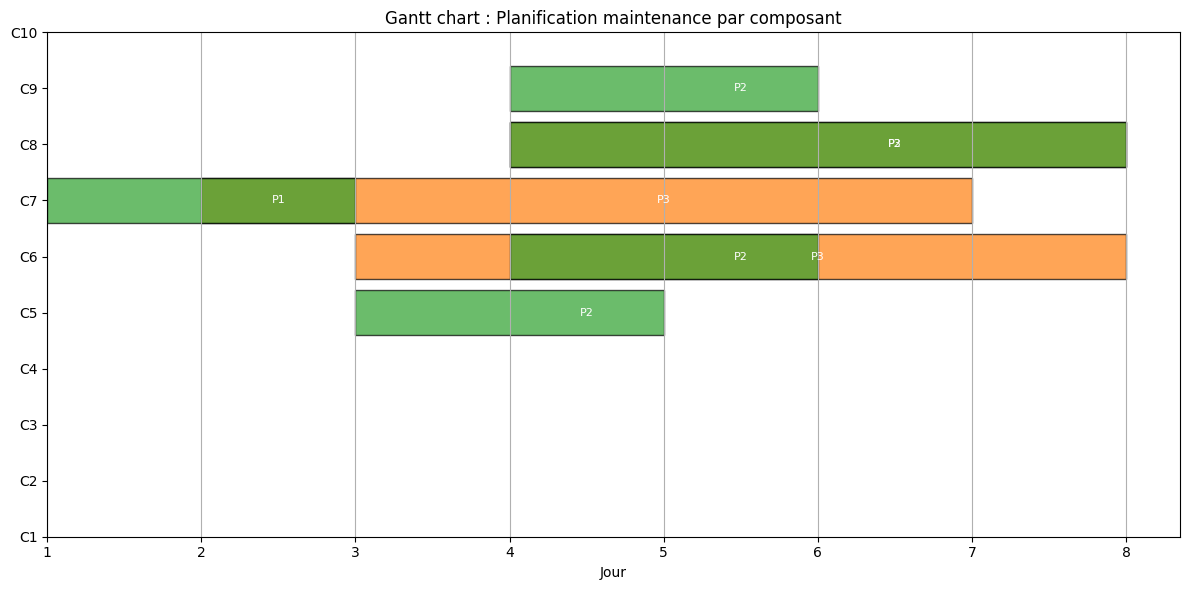

C:\Users\hp\AppData\Local\Temp\ipykernel_6596\4178835101.py:85: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sns.heatmap(heat_data.applymap(lambda x: len(x) > 0), cmap="YlGnBu", cbar=False, linewidths=.5, linecolor='gray')


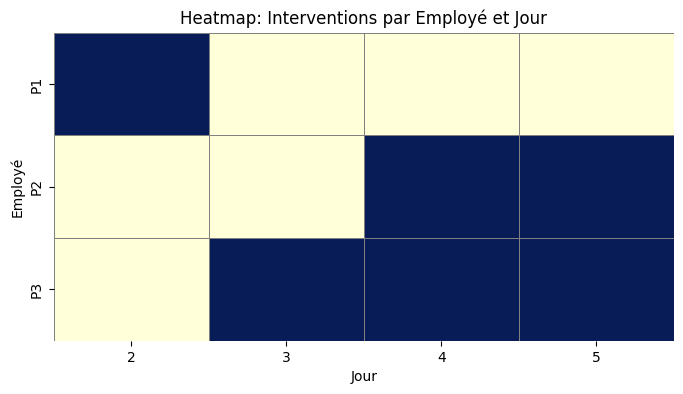

Coût total minimisé : 1341 unités monétaires


In [30]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpBinary

# --- Données simulées ---
random.seed(42)

components = [f"C{i}" for i in range(1, 11)]
skills = ["Meca", "Elec", "Hydrau"]
employees = ["P1", "P2", "P3", "P4"]
days = list(range(1, 6))

phi = {p: 8 for p in employees}
delta = {c: random.randint(1, 2) for c in components}
lambda1 = 1000

alpha = {(s, p): random.choice([0, 1]) for s in skills for p in employees}
tau = {(c, s, p): random.randint(2, 6)
       for c in components for s in skills for p in employees if alpha.get((s, p), 0) == 1}
C = {(c, s, p, t): random.randint(100, 300) for (c, s, p) in tau.keys() for t in days}
beta = {(random.choice(components), random.choice(days)): 1 for _ in range(8)}

# --- Modèle ---
model = LpProblem("Planification_Maintenance", LpMinimize)
x = LpVariable.dicts("x", [(c, s, p, t) for (c, s, p) in tau.keys() for t in days], cat=LpBinary)
z = LpVariable.dicts("z", [(c, s, t) for c in components for s in skills for t in days], cat=LpBinary)

cost_term = lpSum(C.get((c, s, p, t), 0) * x[(c, s, p, t)] for (c, s, p) in tau.keys() for t in days)
penalty_term = lpSum(beta.get((c, t), 0) * (1 - lpSum(z[(c, s, tt)] for tt in days if t <= tt <= t + delta[c]))
                     for c in components for s in skills for t in days if beta.get((c, t), 0) == 1)
model += cost_term + lambda1 * penalty_term

for (c, s, p) in tau.keys():
    for t in days:
        model += x[(c, s, p, t)] <= z[(c, s, t)]

for c in components:
    for s in skills:
        for t in days:
            model += lpSum(x[(c, s, p, t)] for p in employees if (c, s, p) in tau.keys()) == z[(c, s, t)]

for p in employees:
    for t in days:
        model += lpSum(tau[(c, s, p)] * x[(c, s, p, t)]
                       for (c, s, p_) in tau.keys() if p_ == p) <= phi[p]

for c in components:
    for s in skills:
        for t in days:
            if beta.get((c, t), 0) == 1:
                model += lpSum(z[(c, s, tt)] for tt in days if t <= tt <= t + delta[c]) == 1

# --- Résolution ---
model.solve()

# --- Extraction résultats ---
planification = []
for (c, s, p, t), var in x.items():
    if var.varValue == 1:
        planification.append({"Composant": c, "Compétence": s, "Employé": p, "Jour": t, "Durée": tau[(c, s, p)], "Coût": C[(c, s, p, t)]})

df_plan = pd.DataFrame(planification)

# --- Affichage Gantt simple par composant ---
plt.figure(figsize=(12, 6))
colors = {'Meca':'tab:blue', 'Elec':'tab:orange', 'Hydrau':'tab:green'}
for i, c in enumerate(components):
    df_c = df_plan[df_plan.Composant == c]
    for _, row in df_c.iterrows():
        plt.barh(i, row.Durée, left=row.Jour - 1, color=colors[row.Compétence], edgecolor='black', alpha=0.7)
        plt.text(row.Jour - 0.5 + row.Durée/2, i, f"{row.Employé}", ha='center', va='center', color='white', fontsize=8)
plt.yticks(range(len(components)), components)
plt.xlabel("Jour")
plt.title("Gantt chart : Planification maintenance par composant")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# --- Heatmap des compétences par employé et jour ---
heat_data = df_plan.groupby(['Employé', 'Jour'])['Compétence'].apply(lambda x: ','.join(sorted(set(x)))).unstack(fill_value='')

plt.figure(figsize=(8, 4))
sns.heatmap(heat_data.applymap(lambda x: len(x) > 0), cmap="YlGnBu", cbar=False, linewidths=.5, linecolor='gray')
plt.title("Heatmap: Interventions par Employé et Jour")
plt.xlabel("Jour")
plt.ylabel("Employé")
plt.show()

# --- Résumé des coûts ---
cout_total = df_plan.Coût.sum()
print(f"Coût total minimisé : {cout_total} unités monétaires")


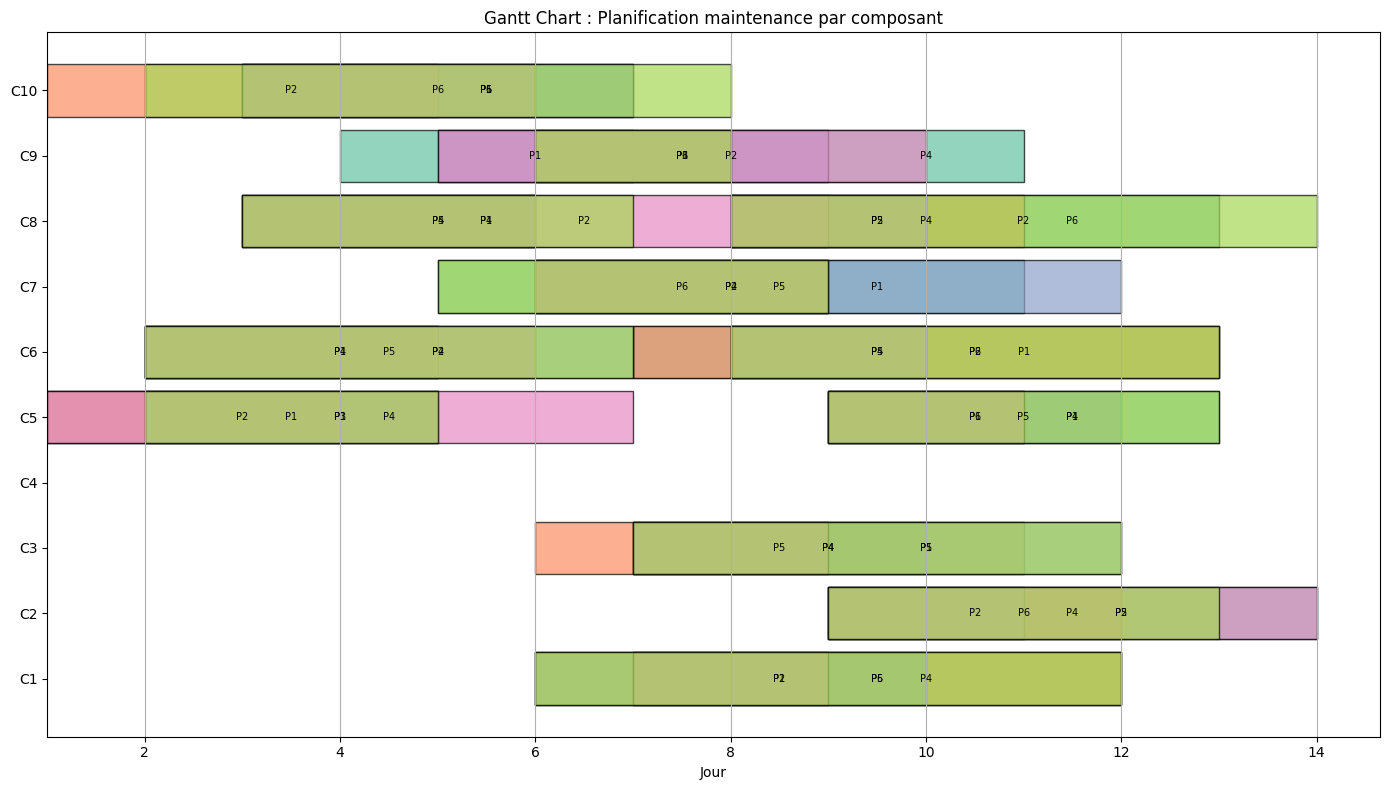

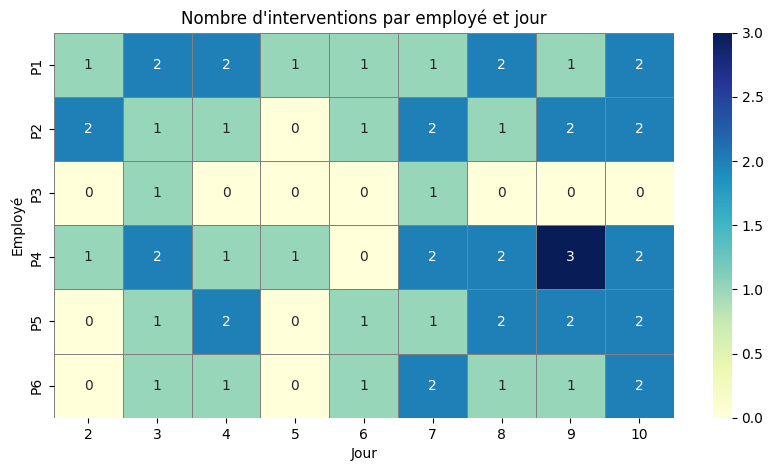

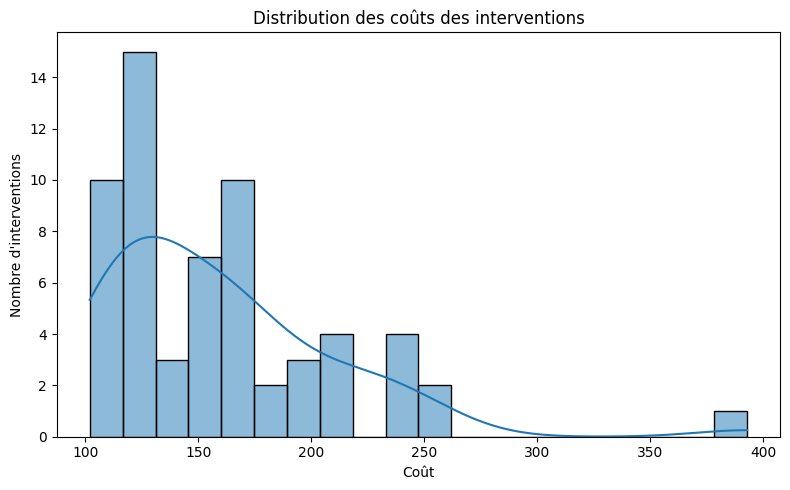

Coût total minimisé : 9731 unités monétaires


In [32]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpBinary

# --- Génération données plus grandes ---
random.seed(123)

components = [f"C{i}" for i in range(1, 11)]
skills = [f"S{i}" for i in range(1, 6)]
employees = [f"P{i}" for i in range(1, 7)]
days = list(range(1, 11))

phi = {p: 8 for p in employees}
delta = {c: random.randint(1, 3) for c in components}
lambda1 = 1000

alpha = {(s, p): random.choices([0, 1], weights=[0.3, 0.7])[0] for s in skills for p in employees}
tau = {(c, s, p): random.randint(2, 6)
       for c in components for s in skills for p in employees if alpha.get((s, p), 0) == 1}
C = {(c, s, p, t): random.randint(100, 500) for (c, s, p) in tau.keys() for t in days}
beta = {(random.choice(components), random.choice(days)): 1 for _ in range(20)}

# --- Modèle ---
model = LpProblem("Planification_Maintenance", LpMinimize)
x = LpVariable.dicts("x", [(c, s, p, t) for (c, s, p) in tau.keys() for t in days], cat=LpBinary)
z = LpVariable.dicts("z", [(c, s, t) for c in components for s in skills for t in days], cat=LpBinary)

cost_term = lpSum(C.get((c, s, p, t), 0) * x[(c, s, p, t)] for (c, s, p) in tau.keys() for t in days)
penalty_term = lpSum(beta.get((c, t), 0) * (1 - lpSum(z[(c, s, tt)] for tt in days if t <= tt <= t + delta[c]))
                     for c in components for s in skills for t in days if beta.get((c, t), 0) == 1)
model += cost_term + lambda1 * penalty_term

for (c, s, p) in tau.keys():
    for t in days:
        model += x[(c, s, p, t)] <= z[(c, s, t)]

for c in components:
    for s in skills:
        for t in days:
            model += lpSum(x[(c, s, p, t)] for p in employees if (c, s, p) in tau.keys()) == z[(c, s, t)]

for p in employees:
    for t in days:
        model += lpSum(tau[(c, s, p)] * x[(c, s, p, t)]
                       for (c, s, p_) in tau.keys() if p_ == p) <= phi[p]

for c in components:
    for s in skills:
        for t in days:
            if beta.get((c, t), 0) == 1:
                model += lpSum(z[(c, s, tt)] for tt in days if t <= tt <= t + delta[c]) == 1

# --- Résolution ---
model.solve()

# --- Extraction résultats ---
planification = []
for (c, s, p, t), var in x.items():
    if var.varValue == 1:
        planification.append({"Composant": c, "Compétence": s, "Employé": p, "Jour": t,
                             "Durée": tau[(c, s, p)], "Coût": C[(c, s, p, t)]})

df_plan = pd.DataFrame(planification)

# --- Visualisation Gantt par composant ---
plt.figure(figsize=(14, 8))
colors = sns.color_palette("Set2", len(skills))
color_map = dict(zip(skills, colors))
for i, c in enumerate(components):
    df_c = df_plan[df_plan.Composant == c]
    for _, row in df_c.iterrows():
        plt.barh(i, row.Durée, left=row.Jour - 1, color=color_map[row.Compétence], edgecolor='black', alpha=0.7)
        plt.text(row.Jour - 0.5 + row.Durée/2, i, row.Employé, ha='center', va='center', fontsize=7, color='black')
plt.yticks(range(len(components)), components)
plt.xlabel("Jour")
plt.title("Gantt Chart : Planification maintenance par composant")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# --- Heatmap interventions par employé et jour ---
heatmap_data = df_plan.groupby(['Employé', 'Jour']).size().unstack(fill_value=0)
plt.figure(figsize=(10, 5))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", cbar=True, linewidths=0.5, linecolor='gray')
plt.title("Nombre d'interventions par employé et jour")
plt.xlabel("Jour")
plt.ylabel("Employé")
plt.show()

# --- Histogramme des coûts ---
plt.figure(figsize=(8, 5))
sns.histplot(df_plan.Coût, bins=20, kde=True)
plt.title("Distribution des coûts des interventions")
plt.xlabel("Coût")
plt.ylabel("Nombre d'interventions")
plt.tight_layout()
plt.show()

# --- Résumé des coûts ---
total_cost = df_plan.Coût.sum()
print(f"Coût total minimisé : {total_cost} unités monétaires")


In [36]:
import plotly.express as px

def gantt_plotly(df_plan):
    # Création colonne "Début" et "Fin"
    df_plan['Start'] = df_plan['Jour'] - 1
    df_plan['Finish'] = df_plan['Start'] + df_plan['Durée']

    fig = px.timeline(
        df_plan,
        x_start="Start",
        x_end="Finish",
        y="Composant",
        color="Compétence",
        text="Employé",
        title="Planification maintenance par composant et compétence",
        hover_data=["Employé", "Durée", "Coût"]
    )

    fig.update_yaxes(autorange="reversed")  # Inverse l'axe Y pour une lecture top->down
    fig.update_traces(textposition='inside')
    fig.show()

# Appelle cette fonction avec ton dataframe df_plan
gantt_plotly(df_plan)


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [37]:
import plotly.express as px

def gantt_plotly(df_plan):
    df_plan['Start'] = df_plan['Jour'] - 1
    df_plan['Finish'] = df_plan['Start'] + df_plan['Durée']
    
    fig = px.timeline(
        df_plan,
        x_start="Start",
        x_end="Finish",
        y="Composant",
        color="Compétence",
        text="Employé",
        title="Planification maintenance par composant et compétence",
        hover_data=["Employé", "Durée", "Coût"]
    )
    
    fig.update_yaxes(autorange="reversed")
    fig.update_traces(textposition='inside')
    
    # Affiche ou sauvegarde selon ton environnement
    try:
        fig.show()
    except:
        fig.write_html("planification_gantt.html")
        print("Graphique sauvegardé en planification_gantt.html")

# Appelle avec ton dataframe df_plan
gantt_plotly(df_plan)


Graphique sauvegardé en planification_gantt.html


In [40]:
import pandas as pd
import plotly.express as px

def gantt_plotly(df_plan):
    start_date = pd.to_datetime("2025-01-01")
    df_plan['Start'] = df_plan['Jour'].apply(lambda x: start_date + pd.Timedelta(days=x-1))
    df_plan['Finish'] = df_plan['Start'] + pd.to_timedelta(df_plan['Durée'], unit='D')

    fig = px.timeline(
        df_plan,
        x_start="Start",
        x_end="Finish",
        y="Composant",
        color="Compétence",
        text="Employé",
        title="Planification maintenance par composant et compétence",
        hover_data=["Employé", "Durée", "Coût"]
    )
    fig.update_yaxes(autorange="reversed")
    fig.update_traces(textposition='inside')
    
    # Export en HTML
    fig.write_html("planification_gantt.html")
    print("Graphique sauvegardé dans planification_gantt.html")

# Exemple d’appel avec ton dataframe df_plan
gantt_plotly(df_plan)


Graphique sauvegardé dans planification_gantt.html
